# Qubit Tune-up with SHF Instruments

In this notebook we demonstrate qubit tuneup with the LabOne Q software, implemented as a sequence of experiments. 

Before starting the experiments, we define a set of initial qubit parameters, as might be known from fabrication.


These parameters can then be used to update the baseline calibration used in the experiments.

## 0. General Imports and Definitions
### 0.1 Python Imports 

In [1]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

# for saving results and pulse sheets
from pathlib import Path
import datetime
from datetime import date
import pandas as pd
import time 
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import sys

### 0.2 Function Definitions

In [2]:
# define sweep parameter
def create_readout_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"res_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        stop=stop_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        count=num_points,
    )

def res_spec_calib(frequency_sweep, amplitude_sweep=None):
   exp_calibration = Calibration()
   # sets the oscillator of the experimental measure signal
   my_osc = Oscillator(
           "readout_osc",
           frequency=frequency_sweep,
           modulation_type=ModulationType.HARDWARE,
   )
   exp_calibration["measure"] = SignalCalibration(     # for spectroscopy, use the hardware oscillator of the QA, and set the sweep parameter as frequency
       oscillator=my_osc,
       amplitude=amplitude_sweep,
   )
   exp_calibration["acquire"] = SignalCalibration(
       oscillator=my_osc,
   )
   return exp_calibration

# signal maps for the qubit readout only
def res_spec_map(qubit):
    signal_map = {
        "measure": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

# create gaussian square pulse for readout
def create_readout_pulse(
    qubit, sigma=0.2
):
    readout_pulse = pulse_library.gaussian_square(
        uid=f"readout_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined['readout_len'],
        amplitude=qubit.parameters.user_defined['readout_amp'],
        width=qubit.parameters.user_defined['readout_len'] * 0.9,
        sigma=sigma,
    )
    return readout_pulse

# qubit spectroscopy freq sweep
def create_drive_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"drive_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        stop=stop_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        count=num_points,
    )

# define square pulse for qubit spec
def create_drive_spec_pulse(qubit, amp = 0.95):
    pulse = pulse_library.const(
        uid=f"drive_spec_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=amp, #max power to start
    )
    return pulse

# signal map for qubit drive and readout
def signal_map_default(qubit):
    signal_map = {
        "drive": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

#define gaussian pulse for qubit drive
def create_rabi_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=1,
    )

# define qubit drive rabi sweep
def create_rabi_amp_sweep(qubit, amp_num, uid="rabi_amp"):
    amp_min = 0.1
    amp_max = min([qubit.parameters.user_defined['amplitude_pi'] * 2.2, 1.0])
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

# define delay time sweep for Ramsey, T1, echo
def create_delay_sweep(
    start=0, stop=50e-6, count=100, axis_name="Time [s]"
):
    time_sweep = LinearSweepParameter(
        uid="time_sweep_param", start=start, stop=stop, count=count, axis_name=axis_name
    )
    return time_sweep

# define ramsey drive pulse
def create_ramsey_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'] / 2,
    )

# define T1 drive pulse
def create_T1_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

def create_pi_2_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_2_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi']/2,
    )

def create_pi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

def data_directory_update():
    date = datetime.date.today()
    datadir = Path('data/' + str(date) + '/')
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    return datadir
datadir = data_directory_update()

def live_plotter(fig, new_data):
    pass

def non_redund_save_fig(fig, name):
# A function to prevent figure overwrite issues
    datadir = data_directory_update()
    i = 1
    while True:
        fig_name = Path(str(datadir) + f'/{name}_{i}.png')
        if os.path.isfile(fig_name) is False:
            fig_name = Path(str(datadir) + f'/{name}_{i}')
            fig.savefig(fig_name)
            break
        else:
            i = i+1

def non_redund_save_pd(pd_data, name):
    datadir = data_directory_update()
    i = 1
    while True:
        pd_name = Path(str(datadir) + f'/{name}_{i}.csv')
        if os.path.isfile(pd_name) is False:
            pd_name = Path(str(datadir) + f'/{name}_{i}.csv')
            pd_data.to_csv(pd_name)
            break
        else:
            i += 1

def non_redund_save_csv(csv_data, name):
    datadir = data_directory_update()
    i = 1
    while True:
        csv_name = Path(str(datadir) + f'/{name}_{i}.csv')
        if os.path.isfile(csv_name) is False:
            csv_name = Path(str(datadir) + f'/{name}_{i}.csv')
            csv_data.to_csv(csv_name)
            break
        else:
            i += 1

## 1. Define the Instrument Setup and Required Experimental Parameters
### 1.1 Create device setup

Create the device setup from the descriptor, and apply some convenient mapping to instruments and logical signals.

In [5]:
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12195
    uid: device_shfqc
    interface: 1gbe
    options: SHFQC/PLUS/QC6CH
    qachannels:
        0:
            output:
                rflfinterlock: False

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

# /dev12195/qachannels/0/output/rflfinterlock


In [6]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

### 1.2 Qubit Parameters

A python dictionary containing all parameters needed to control and readout the qubits - frequencies, pulse lengths, timings
<!--  -->
May initially contain only the design parameters and will be updated with measurement results during the tuneup procedure

In [7]:
'''This should be a Transmon object even though a more general Qubit object is present. This is because
a more general Qubit object has LF/RF input/output range coupling automatically turned on and I cannot
seem to be able to turn it off'''
q0 = Transmon.from_logical_signal_group(
    uid="q0",
    lsg=device_setup.logical_signal_groups["q0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=1.5e9,
        readout_resonator_frequency=7112100421,
        readout_lo_frequency=7e9,
        readout_integration_delay=95e-9,
        readout_range_out=-20,
        readout_range_in=10,
        drive_lo_frequency=3e9,
        drive_range=0,
        user_defined={
            "amplitude_pi": 0.95,
            "pulse_length": 50e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.9,
            "reset_length": 5e-6,
        }
    )
)

In [668]:
#Finish calibrating SHFQC with qubit parameters
qubits = [q0]
for qubit in qubits:
    device_setup.set_calibration(qubit.calibration())

#Choose which qubit will be measured
measure_q = q0
# print(measure_q)

### 2.2 Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments

In [669]:
# perform experiments in emulation mode or on hardware - if True, also generate dummy data for fitting
emulate = False

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.09.18 12:15:12.043] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is C:\Users\QNL\ZIScripts\LabOneQ\laboneq_output\log
[2024.09.18 12:15:12.045] INFO    VERSION: laboneq 2.36.0
[2024.09.18 12:15:12.046] INFO    Connecting to data server at localhost:8004
[2024.09.18 12:15:12.393] INFO    Configuring the device setup
[2024.09.18 12:15:12.411] INFO    The device setup is configured


## 3. Qubit Tuneup - Experimental Sequence

Sequence of experiments for tuneup from scratch of a superconducting qubit in circuit QED architecture 

### 3.1 Resonator Spectroscopy: CW

Find the resonance frequency of the qubit readout resonator by looking at the transmission or reflection of a probe signal applied through the readout line

#### 3.1.1 Additional Experimental Parameters

Define the frequency scan

#### 3.1.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [670]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
def res_spectroscopy_CW(freq_sweep, exp_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=exp_settings["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire",
                    handle="res_spec",
                    length=exp_settings["integration_time"],
                )
            with exp_spec.section(uid="delay", length=1e-6):
                # holdoff time after signal acquisition
                exp_spec.reserve(signal="measure")

    return exp_spec
# print(exp_spec)

#### 3.1.3 Run and Evaluate Experiment
Runs the experiment and evaluates the data returned by the measurement

# Resonator characterization

In [940]:
device_setup.set_calibration(measure_q.calibration())

In [947]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -1e6
stop_freq = 2e6
num_points = 101
integration_time = 5e-3
num_averages = 1 #actually just number of averages this time

res = (stop_freq + (-start_freq))/(num_points*1e6)
print(f'resolution = {res} MHz')

resolution = 0.0297029702970297 MHz


In [948]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [949]:
exp_spec.set_signal_map(res_spec_map(measure_q))

In [950]:
# run the experiment on the open instrument session
compiled_res_spec = session.compile(exp_spec)

[2024.09.18 16:33:23.663] INFO    Starting LabOne Q Compiler run...
[2024.09.18 16:33:23.682] INFO    Schedule completed. [0.011 s]
[2024.09.18 16:33:23.706] INFO    Code generation completed for all AWGs. [0.023 s]
[2024.09.18 16:33:23.707] INFO    Completed compilation step 1 of 1. [0.036 s]
[2024.09.18 16:33:23.710] INFO     ────────────────────────────────────────────────────────────────── 
[2024.09.18 16:33:23.710] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.09.18 16:33:23.710] INFO     ────────────────────────────────────────────────────────────────── 
[2024.09.18 16:33:23.710] INFO      device_shfqc     0         25            0           0         0  
[2024.09.18 16:33:23.710] INFO     ────────────────────────────────────────────────────────────────── 
[2024.09.18 16:33:23.710] INFO      TOTAL                      25            0                     0  
[2024.09.18 16:33:23.710] INFO     ────────────────────────────────────────────────────

In [951]:
res_spec_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")

[2024.09.18 16:33:23.921] INFO    Configuring the device setup
[2024.09.18 16:33:23.943] INFO    The device setup is configured
[2024.09.18 16:33:24.744] INFO    Starting near-time execution...
[2024.09.18 16:33:25.652] INFO    Finished near-time execution.
File saved as Results_Needed/res_spec_results_20240918T163325.json


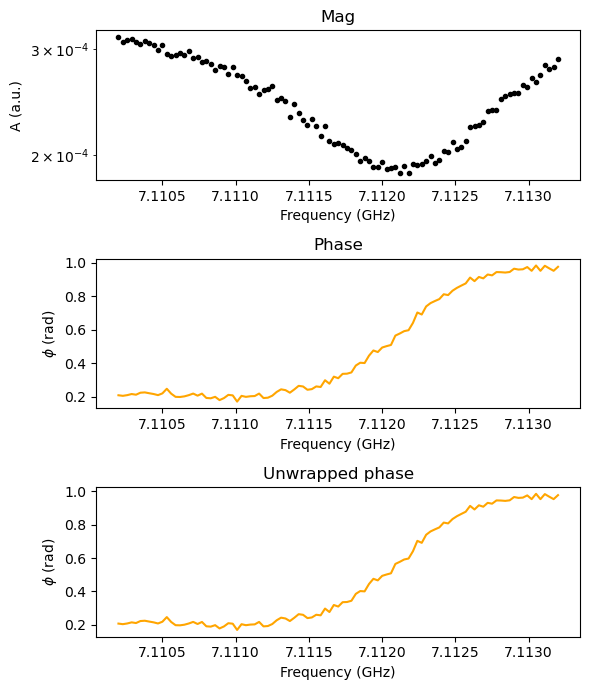

In [1113]:
electrical_delay = 94e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("A (a.u.)")
ax1.set_title('Mag')
ax1.set_yscale("log")

ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_title('Phase')

ax3.set_xlabel("Frequency (GHz)")
ax3.set_ylabel("$\\phi$ (rad)")
ax3.set_title('Unwrapped phase')

# vl = [6.8185]
# for _vl in vl:
#     ax1.axvline(vl, ls='-', color='tab:blue')
#     ax2.axvline(vl, ls='-', color='tab:blue')
#     ax3.axvline(vl, ls='-', color='tab:blue')

plt.tight_layout()
plt.show()

Resonant frequency: 7112069707.979243 GHz


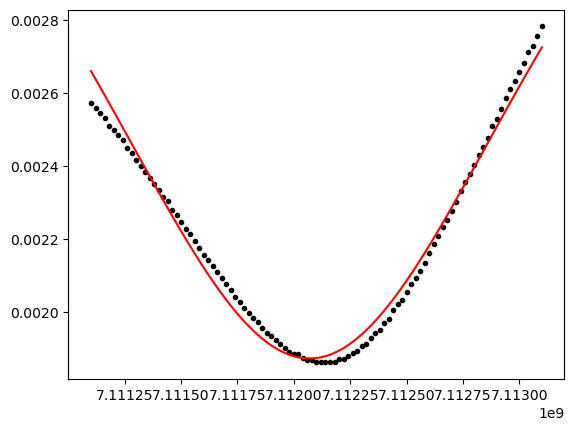

In [317]:
#Lorentzian fit requires roughly close starting values
(p_opt, b) = lorentzian.fit(
    spec_freq,
    abs(spec_res),
    100e3,
    q0.parameters.readout_resonator_frequency,
    -1e7,
    1,
    plot=True,
)
opt_freq = p_opt[1]
print(f"Resonant frequency: {opt_freq} GHz")

## Resonator vs flux 

### resonator spectroscopy setup

In [1171]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -1e5
stop_freq = 1e5
num_points = 1

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 14

readout_pulse = create_readout_pulse(measure_q)

#### 3.2.2 Experiment Definition

In [1153]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [1154]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [1155]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [1192]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.10.08 10:18:04.204] INFO    Starting LabOne Q Compiler run...
[2024.10.08 10:18:04.206] INFO    Schedule completed. [0.000 s]
[2024.10.08 10:18:04.212] INFO    Code generation completed for all AWGs. [0.005 s]
[2024.10.08 10:18:04.213] INFO    Completed compilation step 1 of 1. [0.007 s]
[2024.10.08 10:18:04.216] INFO     ────────────────────────────────────────────────────────────────── 
[2024.10.08 10:18:04.216] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.10.08 10:18:04.217] INFO     ────────────────────────────────────────────────────────────────── 
[2024.10.08 10:18:04.218] INFO      device_shfqc     0         14            0           1      8000  
[2024.10.08 10:18:04.218] INFO     ────────────────────────────────────────────────────────────────── 
[2024.10.08 10:18:04.219] INFO      TOTAL                      14            0                  8000  
[2024.10.08 10:18:04.219] INFO     ────────────────────────────────────────────────────

C:\Users\QNL\ZIScripts\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-10-08-10-18-04.html

#### 3.2.4 Run and Evaluate Experiment

In [27]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.09.18 09:01:59.504] INFO    Configuring the device setup
[2024.09.18 09:01:59.535] INFO    The device setup is configured
[2024.09.18 09:02:00.128] INFO    Starting near-time execution...
[2024.09.18 09:02:00.660] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240918T090200.json


7111700000.0


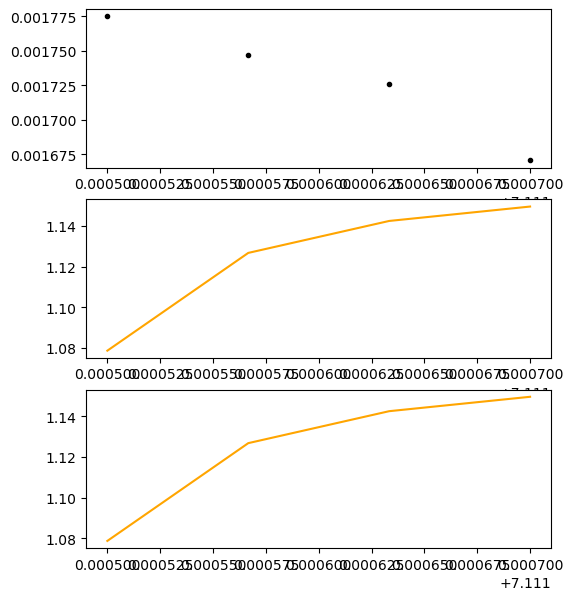

In [28]:
electrical_delay = 91.68e-9

# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
print(spec_freq.max())
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

# ax1.set_ylabel("A (a.u.)")
# # ax1.set_title('Mag')

# ax2.set_ylabel("$\\phi$ (rad)")
# # ax2.set_title('Wrapped phase')

# ax3.set_ylabel("$\\phi$ (rad)")
# # ax3.set_title('Unwrapped phase')
# ax3.set_xlabel("Frequency (GHz)")

# vl = []
# for _vl in vl:
#     ax1.axvline(_vl, ls='-', 
#                 # color='tab:blue',
#                )
#     ax2.axvline(_vl, ls='-', 
#                 # color='tab:blue',
#                )
#     ax3.axvline(_vl, ls='-', 
#                 # color='tab:blue',
#                )

# plt.tight_layout()

# plt.axvline(measure_q.parameters.readout_resonator_frequency*1e-9)

### Dual Flux Control (Spectroscopy vs Flux)

In [1157]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
coil = GS200('yoko_left', address = 'TCPIP0::192.168.4.208::inst0::INSTR')
dc = GS200('yoko_right', address = 'TCPIP0::192.168.4.157::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91PC11413, firmware:2.02) in 0.03s


KeyError: 'Another instrument has the name: yoko_left'

In [1158]:
dc.ramp_current(0e-3, 1e-6,0)
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)
dc.output('on')

coil.ramp_current(0e-3, 1e-6,0)
coil.off()
coil.output('off')
coil.source_mode('CURR')
coil.ramp_current(0e-3, 1e-6,0)
coil.output('on')

## Dual Flux Calibration Sweep (no coil response presently)

In [1197]:
plot = False  # plot individual resonator spectroscopy
dc.current_range(0.01)
coil.current_range(0.01)

start_curr = -715e-6
stop_curr = 875e-6
current_sweep = np.linspace(start_curr,stop_curr, 121)

dc.ramp_current(0e-3, 1e-6, 0.02)
dc.output('off')
dc.source_mode('CURR')
dc.output('on')
coil.ramp_current(0e-3, 1e-6, 0.02)
coil.output('off')
coil.source_mode('CURR')
coil.output('on')

sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    coil_current = (48/1590)*(current-80e-6)+36e-6
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc.ramp_current(current, 0.5e-6, 0.02)
    coil.ramp_current(coil_current, 0.5e-6, 0.02)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

step 0
current: -0.000715
[2024.10.08 10:54:20.238] INFO    Configuring the device setup
[2024.10.08 10:54:20.266] INFO    The device setup is configured
[2024.10.08 10:54:20.924] INFO    Starting near-time execution...
[2024.10.08 10:54:21.530] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20241008T105421.json
step 1
current: -0.00070175
[2024.10.08 10:54:22.846] INFO    Starting near-time execution...
[2024.10.08 10:54:23.203] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20241008T105423.json
step 2
current: -0.0006885
[2024.10.08 10:54:24.446] INFO    Starting near-time execution...
[2024.10.08 10:54:24.781] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20241008T105424.json
step 3
current: -0.0006752500000000001
[2024.10.08 10:54:26.068] INFO    Starting near-time execution...
[2024.10.08 10:54:26.497] INFO    Finished near-time execution.
File saved as Results_

## 1D Coil Sweep for Diagnostics

In [1193]:
plot = False  # plot individual resonator spectroscopy
dc.current_range(0.01)
coil.current_range(0.01)

start_curr = -100e-6
stop_curr = 100e-6
coil_currents = np.linspace(start_curr,stop_curr, 201)

dc.ramp_current(0e-3, 1e-6, 0.02)
dc.output('off')
dc.source_mode('CURR')
dc.output('on')
coil.ramp_current(0e-3, 1e-6, 0.02)
coil.output('off')
coil.source_mode('CURR')
coil.output('on')

sweep_rspec_results = []
sweep_rspec_freq = []
for i, coil_current in enumerate(coil_currents):
    print('Coil step ' + str(i))
    coil.ramp_current(coil_current, 1e-6, 0.01)
    # run the experiment on qubit 0
    rspec_results = session.run()
    
    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)
    sweep_rspec_freq.append(spec_freq)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

Coil step 0
[2024.10.08 10:18:50.579] INFO    Configuring the device setup
[2024.10.08 10:18:50.614] INFO    The device setup is configured
[2024.10.08 10:18:51.205] INFO    Starting near-time execution...
[2024.10.08 10:18:51.661] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20241008T101851.json
Coil step 1
[2024.10.08 10:18:52.447] INFO    Starting near-time execution...
[2024.10.08 10:18:52.957] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20241008T101853.json
Coil step 2
[2024.10.08 10:18:53.678] INFO    Starting near-time execution...
[2024.10.08 10:18:53.999] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20241008T101854.json
Coil step 3
[2024.10.08 10:18:54.643] INFO    Starting near-time execution...
[2024.10.08 10:18:55.064] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20241008T101855.json
Coil step 4
[2024.10.08 

In [1194]:
np.shape(sweep_rspec_results)

(201, 1)

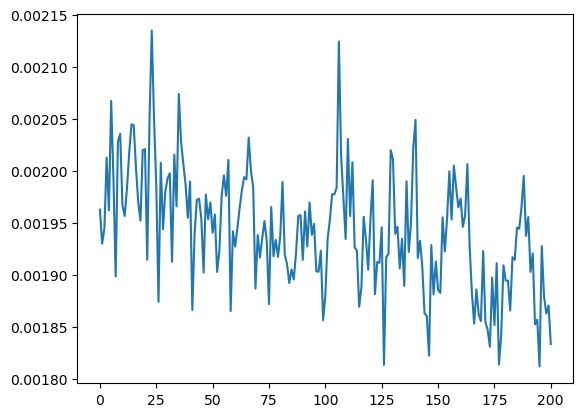

In [1196]:
plt.plot(sweep_rspec_results)

Text(0.5, 1.0, 'LogMag [arb.]')

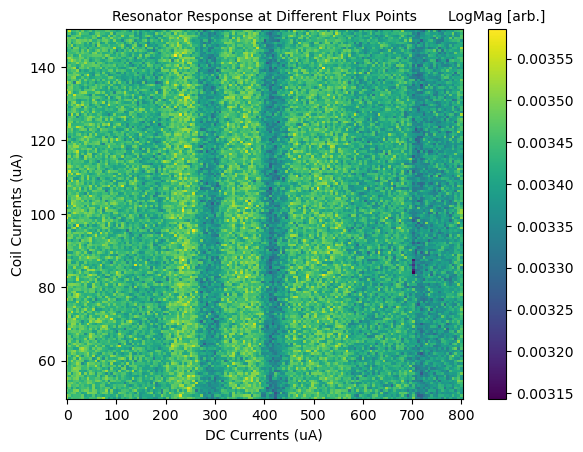

In [1183]:
plt.pcolor(dc_currents*1e6, coil_currents*1e6, np.abs(sweep_rspec_results))
plt.xlabel('DC Currents (uA)')
plt.ylabel('Coil Currents (uA)')
plt.title('Resonator Response at Different Flux Points', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

In [1180]:
plt.pcolor(current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'Resonator Profile while sweeping $\phi$ at $\theta = 0$', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
# plt.axvline(8.8, c='tab:blue', alpha=0.4)
# plt.axhline(6.818, c='tab:purple', alpha=0.4)

ValueError: operands could not be broadcast together with shapes (4,) (150,150) 

# Two-tone with Flux Control

In [38]:
dc.ramp_current(0e-3, 1e-6,0)
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.output('on')

coil.ramp_current(0e-3, 1e-6,0)
coil.off()
coil.output('off')
coil.source_mode('CURR')
coil.output('on')

In [848]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
qspec_range = 500e6
# how many frequency points to measure
# qspec_num = 1001
qspec_num = 41

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

In [953]:
### QB spec
measure_q.parameters.drive_lo_frequency = 3e9

LF_path = False
start_freq = -200e6
stop_freq = 200e6
measure_q.parameters.resonance_frequency_ge = 3e9
measure_q.parameters.user_defined['amplitude_pi'] = 0.99

### RO spec
measure_q.parameters.readout_resonator_frequency = 7.1112e9
measure_q.parameters.user_defined['readout_amp'] = 0.95
measure_q.parameters.readout_range_out=-20
measure_q.parameters.readout_range_in=0
measure_q.parameters.drive_range = 10
measure_q.parameters.user_defined['reset_length'] = 100e-6 #this can be made much smaller to have faster collection
measure_q.parameters.user_defined['pulse_length'] = 100e-09
measure_q.parameters.user_defined['readout_length'] = 5000e-09

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3000000000.0,
│   │   resonance_frequency_ef=None,
│   │   drive_lo_frequency=3000000000.0,
│   │   readout_resonator_frequency=7111200000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=9.5e-08,
│   │   drive_range=10,
│   │   readout_range_out=-20,
│   │   readout_range_in=0,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 1e-07,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_length': 5e-06
│   │   }
│   )
)

In [954]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [955]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter
def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [956]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [957]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q, amp=0.95)
# drive_pulse = create_rabi_drive_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [958]:
measure_q.parameters.user_defined['reset_length'], freq_sweep_q, drive_pulse, readout_pulse

LinearSweepParameter(
│   uid='drive_freq_q0',
│   start=-200000000.0,
│   stop=200000000.0,
│   count=41,
│   axis_name=None
)

PulseFunctional(
│   function='const',
│   uid='drive_spec_pulse_q0',
│   amplitude=0.95,
│   length=1e-07,
│   can_compress=False,
│   pulse_parameters=None
)

PulseFunctional(
│   function='gaussian_square',
│   uid='readout_pulse_q0',
│   amplitude=0.9,
│   length=2e-06,
│   can_compress=False,
│   pulse_parameters={
│   │   'width': 1.8e-06,
│   │   'sigma': 0.2
│   }
)

(0.0001, , , )

In [959]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.09.18 16:34:05.535] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal 'acquire' to SOFTWARE
[2024.09.18 16:34:05.536] INFO    Starting LabOne Q Compiler run...
[2024.09.18 16:34:05.545] INFO    Schedule completed. [0.007 s]
[2024.09.18 16:34:05.589] INFO    Code generation completed for all AWGs. [0.044 s]
[2024.09.18 16:34:05.590] INFO    Completed compilation step 1 of 1. [0.053 s]
[2024.09.18 16:34:05.593] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.09.18 16:34:05.594] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.09.18 16:34:05.595] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.09.18 16:34:05.595] INFO      device_shfqc        0         10            0           1      8000  
[2024.09.18 16:34:05.596] INFO      device_shfqc_sg     0         23            2           1       416  
[2024.09.18 16:34:05.596] INFO     ──────────

In [960]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.09.18 16:34:07.599] INFO    Configuring the device setup
[2024.09.18 16:34:07.610] INFO    The device setup is configured
[2024.09.18 16:34:08.233] INFO    Starting near-time execution...
[2024.09.18 16:34:08.942] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240918T163409.json


In [961]:
emulate=False

11.342952991995734

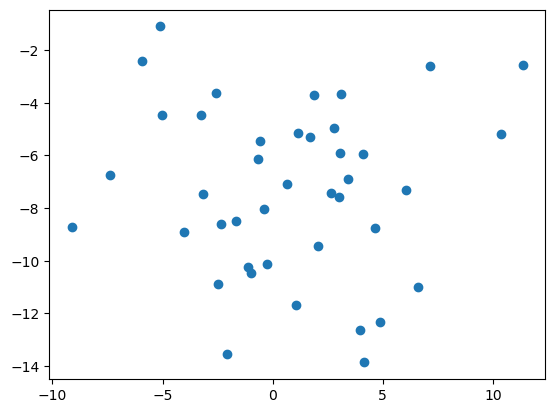

In [962]:
real = qspec_res.real
imag = qspec_res.imag
plt.scatter(real, imag)
real.max()

estimated frequency 2.88 GHz


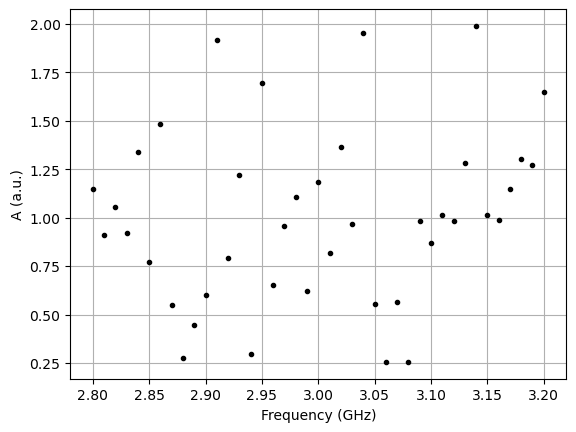

In [963]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.abs(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")
plt.grid()

# plt.axvline(1.162, linestyle = '--', alpha=0.4)
# plt.axvline(1.14, linestyle = '--', alpha=0.4)
# plt.axvline(1.191, linestyle = '--', alpha=0.4)
# plt.axvline(1.160, linestyle = '--', alpha=0.4, color='tab:purple')
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

## Wide Range Spectrum Sweep

### One current value

In [1024]:
%%capture
import math as m
#wide_range_spectrum
#needs to change the LO at least every 900MHz. Instead will move the LO every GHz
spec_start = 1e9
spec_end = 9e9

start_drive_lo = m.ceil(spec_start/400e6)
end_drive_lo = m.floor(spec_end/400e6)
drive_lo_enumerated = np.arange(start_drive_lo, end_drive_lo)*400e6
print(drive_lo_enumerated)
concat_results = []
concat_freq = []
for i, drive_lo in enumerate(drive_lo_enumerated):
    qspec_num = 41
    num_averages = 17 #averages = 2**num_averages. Max=17
    print(i)
    LF_path = False
    if i == 0:
        start_freq = spec_start - drive_lo
        stop_freq = 0
    if i == len(drive_lo_enumerated)-1:
        start_freq = -400e6
        stop_freq = spec_end - drive_lo
    else:
        start_freq = -400e6
        end_freq = 0
    measure_q.parameters.resonance_frequency_ge = drive_lo
    measure_q.parameters.user_defined['amplitude_pi'] = 0.99
    
    measure_q.parameters.readout_resonator_frequency = 7.1112e9
    measure_q.parameters.user_defined['readout_amp'] = 0.9
    
    measure_q.parameters.drive_lo_frequency = drive_lo
    measure_q.parameters.resonance_frequency_ge = drive_lo
    measure_q.parameters.readout_range_out=-5
    measure_q.parameters.readout_range_in=5
    measure_q.parameters.drive_range = 0
    measure_q.parameters.user_defined['reset_length'] = 5e-6
    measure_q.parameters.user_defined['pulse_length'] = 100e-09
    measure_q.parameters.user_defined['readout_length'] = 5000e-09
    
    device_setup.set_calibration(measure_q.calibration())
    freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)
    
    # experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
    exp_calibration_q = Calibration()
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )
    
    # define experiment with frequency sweep for qubit 0
    drive_pulse = create_drive_spec_pulse(measure_q, amp=0.95)
    readout_pulse = create_readout_pulse(measure_q)
    
    #update default calibration to qubit settings
    device_setup.set_calibration(measure_q.calibration())
    
    exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])
    
    # apply calibration and signal map for qubit for this experiment
    exp_qspec.set_calibration(exp_calibration_q)
    exp_qspec.set_signal_map(signal_map_default(measure_q))
    compiled_qspec = session.compile(exp_qspec);
    qspec_results = session.run();
    qspec_res = qspec_results.get_data("qb_spec")
    qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency
    concat_results.append(qspec_res)
    concat_freq.append(qspec_freq)
    
    # timestamp = time.strftime("%Y%m%dT%H%M%S")
    # Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    # session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    # print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")
    # emulate=False

[2024.09.19 19:49:31.335] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal 'acquire' to SOFTWARE
[2024.09.19 19:49:31.336] INFO    Starting LabOne Q Compiler run...
[2024.09.19 19:49:31.345] INFO    Schedule completed. [0.007 s]
[2024.09.19 19:49:31.940] INFO    Code generation completed for all AWGs. [0.594 s]
[2024.09.19 19:49:31.941] INFO    Completed compilation step 1 of 1. [0.603 s]
[2024.09.19 19:49:31.945] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.09.19 19:49:31.945] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.09.19 19:49:31.946] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.09.19 19:49:31.946] INFO      device_shfqc        0         10            0           1      8000  
[2024.09.19 19:49:31.947] INFO      device_shfqc_sg     0         23            2           1       416  
[2024.09.19 19:49:31.947] INFO     ──────────

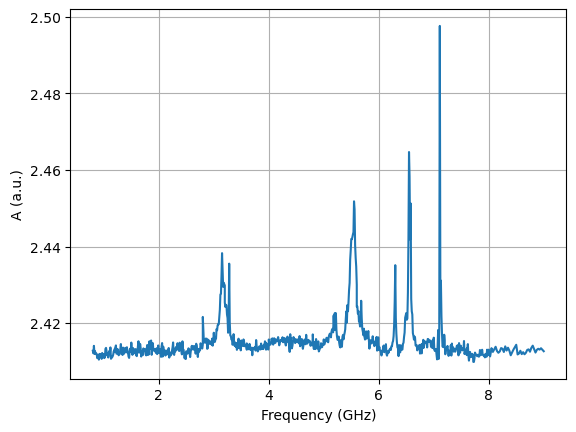

In [1027]:
    # plot measurement data
    fig = plt.figure()
    plt.plot(concat_freq / 1e9, np.angle(concat_results))
    plt.ylabel("A (a.u.)")
    plt.xlabel("Frequency (GHz)")
    plt.grid()
    
    # plt.axvline(1.162, linestyle = '--', alpha=0.4)
    # plt.axvline(1.14, linestyle = '--', alpha=0.4)
    # plt.axvline(1.191, linestyle = '--', alpha=0.4)
    # plt.axvline(1.160, linestyle = '--', alpha=0.4, color='tab:purple')
    # plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
    # print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
    plt.show()

### Spectrum vs Flux

doing (400, 130)/2 + (80,36) = (280,101)

In [1137]:
import math as m
#wide_range_spectrum
#needs to change the LO at least every 900MHz. Instead will move the LO every GHz
spec_start = 1e9
spec_end = 9e9
dc.current_range(0.01)
coil.current_range(0.001)

start_curr = -715e-6 + 200e-6
stop_curr = 875e-6 + 200e-6
start_drive_lo = m.ceil(spec_start/400e6)
end_drive_lo = m.floor(spec_end/400e6)
drive_lo_enumerated = np.arange(start_drive_lo, end_drive_lo)*400e6

current_sweep_append = np.linspace(start_curr,stop_curr, 121)
dc.ramp_current(0e-3, 1e-6, 0)
dc.output('off')
dc.source_mode('CURR')
dc.output('on')
coil.ramp_current(0e-3, 1e-6, 0)
coil.output('off')
coil.source_mode('CURR')
coil.output('on')

curr_sweep_results_append = []
curr_sweep_freq_append = []
for i, current in enumerate(current_sweep):
    print(i)
    if current < 0.001:
        continue
    coil_current = (48/1590)*(current-280e-6)+101e-6
    # coil_current = (48/1590)*(current-80e-6)+36e-6
    print('step ' + str(i))
    print(f'current: {current}')
    dc.ramp_current(current, 0.5e-6, 0)
    coil.ramp_current(coil_current, 0.5e-6, 0)
    concat_results = []
    concat_freq = []
    for i, drive_lo in enumerate(drive_lo_enumerated):
        qspec_num = 41
        num_averages = 17 #averages = 2**num_averages. Max=17
        print(i)
        LF_path = False
        if i == 0:
            start_freq = spec_start - drive_lo
            stop_freq = 0
        if i == len(drive_lo_enumerated)-1:
            start_freq = -400e6
            stop_freq = spec_end - drive_lo
        else:
            start_freq = -400e6
            end_freq = 0
        measure_q.parameters.resonance_frequency_ge = drive_lo
        measure_q.parameters.user_defined['amplitude_pi'] = 0.99
        
        measure_q.parameters.readout_resonator_frequency = 7.1112e9
        measure_q.parameters.user_defined['readout_amp'] = 0.9
        
        measure_q.parameters.drive_lo_frequency = drive_lo
        measure_q.parameters.resonance_frequency_ge = drive_lo
        measure_q.parameters.readout_range_out=-5
        measure_q.parameters.readout_range_in=5
        measure_q.parameters.drive_range = 0
        measure_q.parameters.user_defined['reset_length'] = 5e-6
        measure_q.parameters.user_defined['pulse_length'] = 100e-09
        measure_q.parameters.user_defined['readout_length'] = 5000e-09
        
        device_setup.set_calibration(measure_q.calibration())
        freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)
        
        # experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
        exp_calibration_q = Calibration()
        exp_calibration_q["drive"] = SignalCalibration(
            oscillator=Oscillator(
                frequency=freq_sweep_q,
                modulation_type=ModulationType.HARDWARE,
            ),
        )
        
        # define experiment with frequency sweep for qubit 0
        drive_pulse = create_drive_spec_pulse(measure_q, amp=0.95)
        readout_pulse = create_readout_pulse(measure_q)
        
        #update default calibration to qubit settings
        device_setup.set_calibration(measure_q.calibration())
        
        exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])
        
        # apply calibration and signal map for qubit for this experiment
        exp_qspec.set_calibration(exp_calibration_q)
        exp_qspec.set_signal_map(signal_map_default(measure_q))
        compiled_qspec = session.compile(exp_qspec);
        qspec_results = session.run();
        qspec_res = qspec_results.get_data("qb_spec")
        qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency
        concat_results.append(qspec_res)
        concat_freq.append(qspec_freq)
    concat_results = np.concatenate(np.asarray(concat_results))
    concat_freq = np.concatenate(np.asarray(concat_freq))
    curr_sweep_results_append.append(concat_results)
    curr_sweep_freq_append.append(concat_freq)
results = np.concatenate(np.asarray(curr_sweep_results))
freq = np.concatenate(np.asarray(curr_sweep_freq))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
step 115
current: 0.0010087499999999999
0
[2024.10.02 09:17:22.268] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal 'acquire' to SOFTWARE
[2024.10.02 09:17:22.268] INFO    Starting LabOne Q Compiler run...
[2024.10.02 09:17:22.282] INFO    Schedule completed. [0.007 s]
[2024.10.02 09:17:22.323] INFO    Code generation completed for all AWGs. [0.051 s]
[2024.10.02 09:17:22.323] INFO    Completed compilation step 1 of 1. [0.059 s]
[2024.10.02 09:17:22.323] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.10.02 09:17:22.323] INFO      Device            AWG   SeqC LOC   CT

In [1184]:
import math as m
#wide_range_spectrum
#needs to change the LO at least every 900MHz. Instead will move the LO every GHz
spec_start = 1e9
spec_end = 9e9
dc.current_range(0.01)
coil.current_range(0.01)

start_curr = -595e-6+80e-6
stop_curr = +595e-6+80e-6
start_drive_lo = m.ceil(spec_start/400e6)
end_drive_lo = m.floor(spec_end/400e6)
drive_lo_enumerated = np.arange(start_drive_lo, end_drive_lo)*400e6

current_sweep = np.linspace(start_curr,stop_curr, 119)
dc.ramp_current(0e-3, 1e-6, 0.02)
dc.output('off')
dc.source_mode('CURR')
dc.output('on')
coil.ramp_current(0e-3, 1e-6, 0.02)
coil.output('off')
coil.source_mode('CURR')
coil.output('on')

curr_sweep_results = []
curr_sweep_freq = []
for i, current in enumerate(current_sweep):
    print(i)
    coil_current = (-82/1190)*(current-80e-6)+36e-6 #phi=0, theta sweep
    # coil_current = (48/1590)*(current-280e-6)+101e-6 #theta = 0, phi sweep
    # coil_current = (48/1590)*(current-80e-6)+36e-6 #theta = pi, phi sweep
    print('step ' + str(i))
    print(f'current: {current}')
    dc.ramp_current(current, 0.5e-6, 0.02)
    coil.ramp_current(coil_current, 0.5e-6, 0.02)
    concat_results = []
    concat_freq = []
    for i, drive_lo in enumerate(drive_lo_enumerated):
        qspec_num = 41
        num_averages = 17 #averages = 2**num_averages. Max=17
        print(i)
        LF_path = False
        if i == 0:
            start_freq = spec_start - drive_lo
            stop_freq = 0
        if i == len(drive_lo_enumerated)-1:
            start_freq = -400e6
            stop_freq = spec_end - drive_lo
        else:
            start_freq = -400e6
            end_freq = 0
        measure_q.parameters.resonance_frequency_ge = drive_lo
        measure_q.parameters.user_defined['amplitude_pi'] = 0.99
        
        measure_q.parameters.readout_resonator_frequency = 7.1112e9
        measure_q.parameters.user_defined['readout_amp'] = 0.9
        
        measure_q.parameters.drive_lo_frequency = drive_lo
        measure_q.parameters.resonance_frequency_ge = drive_lo
        measure_q.parameters.readout_range_out=-5
        measure_q.parameters.readout_range_in=5
        measure_q.parameters.drive_range = 0
        measure_q.parameters.user_defined['reset_length'] = 100e-09
        measure_q.parameters.user_defined['pulse_length'] = 100e-09
        measure_q.parameters.user_defined['readout_length'] = 5000e-09
        
        device_setup.set_calibration(measure_q.calibration())
        freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)
        
        # experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
        exp_calibration_q = Calibration()
        exp_calibration_q["drive"] = SignalCalibration(
            oscillator=Oscillator(
                frequency=freq_sweep_q,
                modulation_type=ModulationType.HARDWARE,
            ),
        )
        
        # define experiment with frequency sweep for qubit 0
        drive_pulse = create_drive_spec_pulse(measure_q, amp=0.95)
        readout_pulse = create_readout_pulse(measure_q)
        
        #update default calibration to qubit settings
        device_setup.set_calibration(measure_q.calibration())
        
        exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])
        
        # apply calibration and signal map for qubit for this experiment
        exp_qspec.set_calibration(exp_calibration_q)
        exp_qspec.set_signal_map(signal_map_default(measure_q))
        compiled_qspec = session.compile(exp_qspec);
        qspec_results = session.run();
        qspec_res = qspec_results.get_data("qb_spec")
        qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency
        concat_results.append(qspec_res)
        concat_freq.append(qspec_freq)
    concat_results = np.concatenate(np.asarray(concat_results))
    concat_freq = np.concatenate(np.asarray(concat_freq))
    curr_sweep_results.append(concat_results)
    curr_sweep_freq.append(concat_freq)
results = np.concatenate(np.asarray(curr_sweep_results))
freq = np.concatenate(np.asarray(curr_sweep_freq))

0
step 0
current: -0.000515
0
[2024.10.04 11:59:37.395] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal 'acquire' to SOFTWARE
[2024.10.04 11:59:37.395] INFO    Starting LabOne Q Compiler run...
[2024.10.04 11:59:37.404] INFO    Schedule completed. [0.007 s]
[2024.10.04 11:59:37.446] INFO    Code generation completed for all AWGs. [0.052 s]
[2024.10.04 11:59:37.446] INFO    Completed compilation step 1 of 1. [0.061 s]
[2024.10.04 11:59:37.461] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.10.04 11:59:37.461] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.10.04 11:59:37.461] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.10.04 11:59:37.461] INFO      device_shfqc        0         10            0           1      8000  
[2024.10.04 11:59:37.465] INFO      device_shfqc_sg     0         23            2           1       416  
[2024.10.04 11:

In [1185]:
np.shape(curr_sweep_results)
np.shape(curr_sweep_freq)

(119, 779)

In [ ]:
curr_sweep_results.append(curr_sweep_results_append)
curr_sweep_freq.append(curr_sweep_freq_append)

In [1186]:
normalized_amp_data = []
for i, column in enumerate(curr_sweep_results):
    column = (column - np.mean(column))/np.std(column)
    normalized_amp_data.append(column)
normalized_amp_data = np.asarray(normalized_amp_data).transpose()

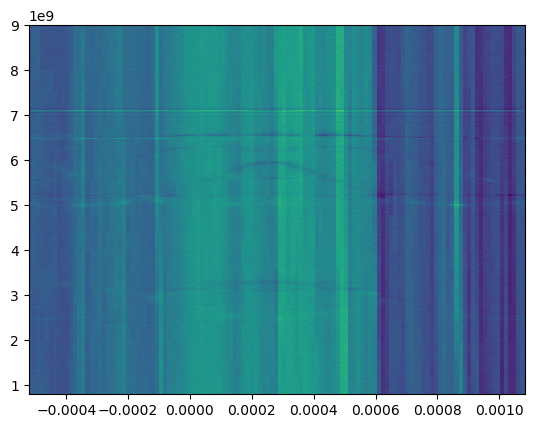

In [1142]:
plt.pcolor(current_sweep, curr_sweep_freq[0], np.abs(curr_sweep_results).T, shading='nearest')

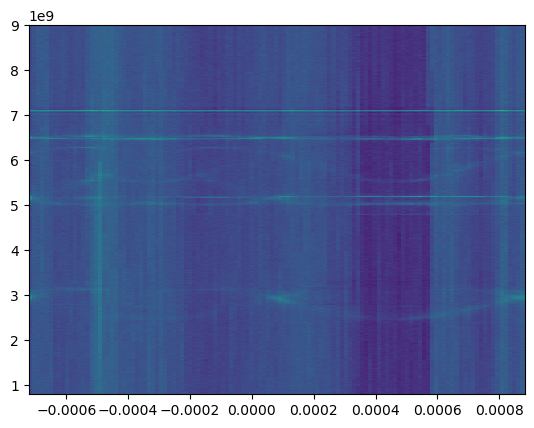

In [1114]:
plt.pcolor(current_sweep, curr_sweep_freq[0], np.abs(curr_sweep_results).T, shading='nearest')

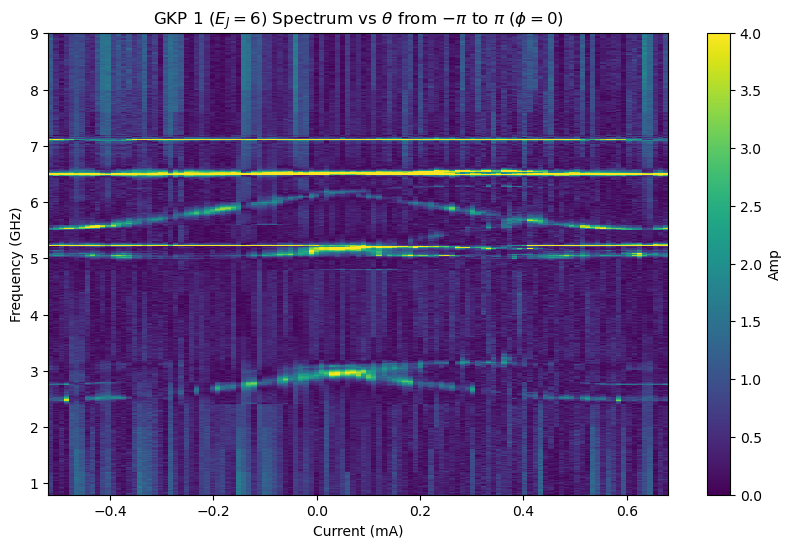

In [1188]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Current (mA)')
ax.set_ylabel('Frequency (GHz)')
ax.set_title(r'GKP 1 ($E_J = 6$) Spectrum vs $\theta$ from $-\pi$ to $\pi$ ($\phi = 0$)')
cmesh_amp = ax.pcolormesh(current_sweep*1e3, curr_sweep_freq[0]/1e9, np.abs(normalized_amp_data), shading='nearest', vmin=-0, vmax=4)
fig.colorbar(cmesh_amp, label='Amp')

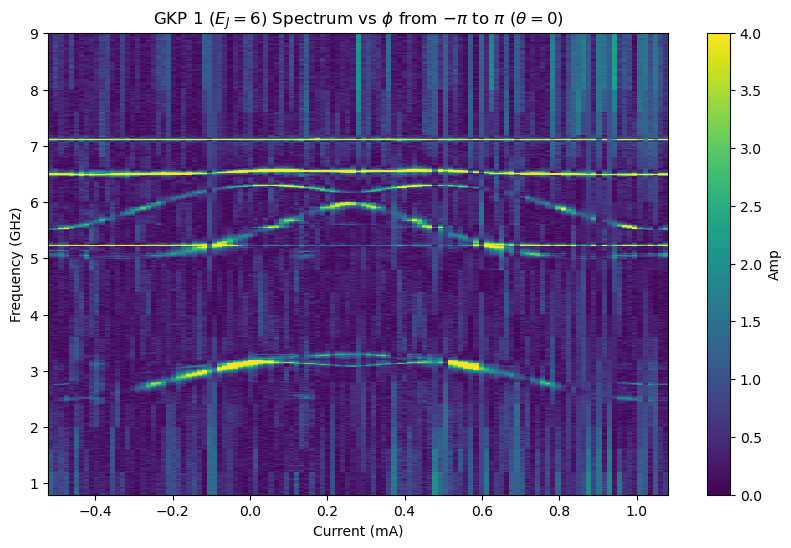

In [1145]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Current (mA)')
ax.set_ylabel('Frequency (GHz)')
ax.set_title(r'GKP 1 ($E_J = 6$) Spectrum vs $\phi$ from $-\pi$ to $\pi$ ($\theta = 0$)')
cmesh_amp = ax.pcolormesh(current_sweep*1e3, curr_sweep_freq[0]/1e9, np.abs(normalized_amp_data), shading='nearest', vmin=-0, vmax=4)
fig.colorbar(cmesh_amp, label='Amp')

In [1189]:
non_redund_save_csv(pd.DataFrame(curr_sweep_results), 'theta0_phisweep_results')
non_redund_save_csv(pd.DataFrame(curr_sweep_freq), 'theta0_phisweep_freq')
non_redund_save_csv(pd.DataFrame(current_sweep), 'theta0_phisweep_currents')

In [ ]:
for power in np.linspace(-30, 10, 9):
    LF_path = False
    qspec_num = 41
    num_averages = 14 #actual_n_averages = 2**num_averages
    measure_q.parameters.drive_range = power
    measure_q.parameters.drive_lo_frequency = 3e9
    measure_q.parameters.resonance_frequency_ge = 3e9
    
    start_freq = -200e6
    stop_freq = 200e6
    device_setup.set_calibration(measure_q.calibration())

    freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)
    # experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
    exp_calibration_q = Calibration()
    
    drive_pulse = create_drive_spec_pulse(measure_q, amp=0.4)
    # drive_pulse = create_rabi_drive_pulse(measure_q)
    
    readout_pulse = create_readout_pulse(measure_q)

    exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])
    
    # apply calibration and signal map for qubit for this experiment
    exp_qspec.set_calibration(exp_calibration_q)
    exp_qspec.set_signal_map(signal_map_default(measure_q))
    
    compiled_qspec = session.compile(exp_qspec)
    qspec_results = session.run()
    
    # get measurement data returned by the instruments
    qspec_res = qspec_results.get_data("qb_spec")
    qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency
    
    if emulate:
        # create some dummy data if running in emulation mode
        qspec_res = lorentzian(
            qspec_freq,
            5e6,
            measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
            -2e6,
            1,
        ) + 0.1 * np.random.rand(len(qspec_freq))
    
    # plot measurement data
    fig = plt.figure()
    plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k")
    plt.ylabel("A (a.u.)")
    plt.xlabel("Frequency (GHz)")
    plt.grid()
    
    # plt.axvline(1.162, linestyle = '--', alpha=0.4)
    # plt.axvline(1.14, linestyle = '--', alpha=0.4)
    # plt.axvline(1.191, linestyle = '--', alpha=0.4)
    # plt.axvline(1.160, linestyle = '--', alpha=0.4, color='tab:purple')
    # plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
    print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
    plt.show()

## Two-tone vs flux
Fine two tone sweep to find half-flux

[2024.07.30 16:50:18.281] INFO    Starting near-time execution...
[2024.07.30 16:50:23.196] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T165023.json
[2024.07.30 16:50:24.985] INFO    Starting near-time execution...
[2024.07.30 16:50:29.948] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T165030.json
[2024.07.30 16:50:31.787] INFO    Starting near-time execution...
[2024.07.30 16:50:36.793] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T165036.json
[2024.07.30 16:50:38.665] INFO    Starting near-time execution...
[2024.07.30 16:50:43.538] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T165043.json
[2024.07.30 16:50:45.235] INFO    Starting near-time execution...
[2024.07.30 16:50:50.299] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T165050.json
[2024.07.30 16:50:52.136] INFO

C:\Users\qnlbe\AppData\Local\Temp\ipykernel_55924\3638700809.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


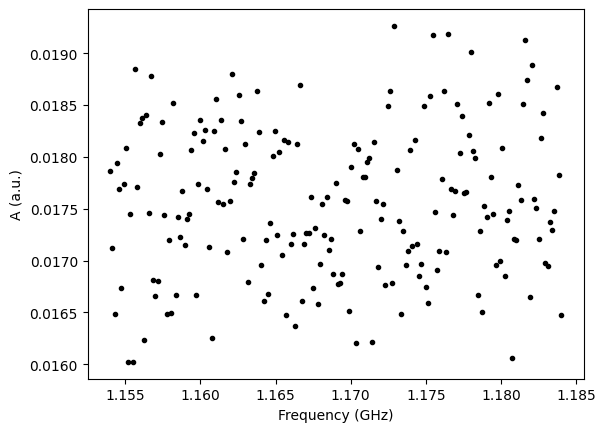

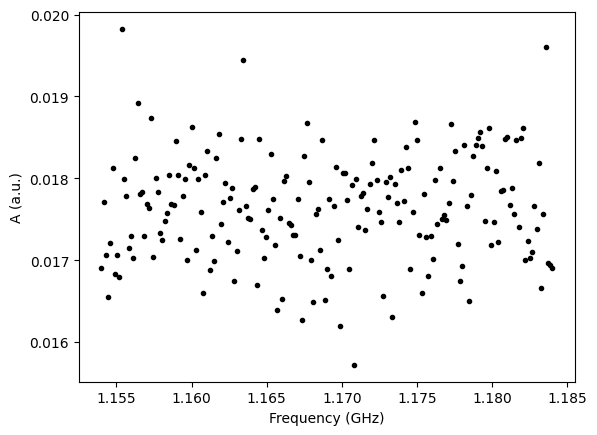

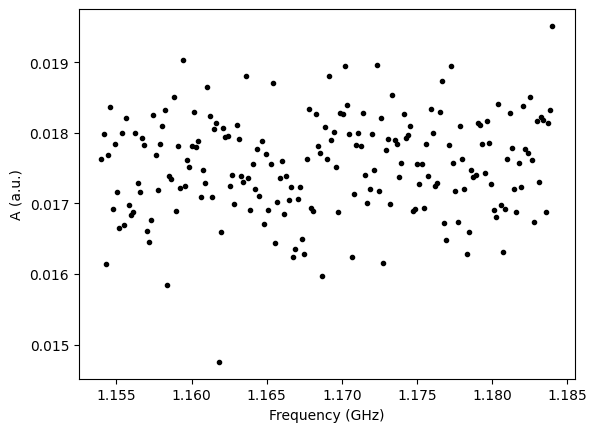

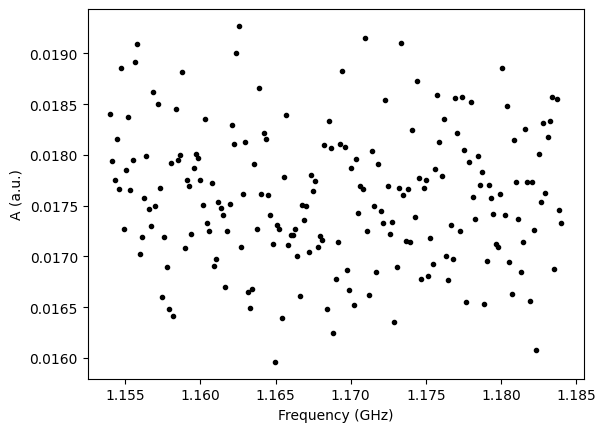

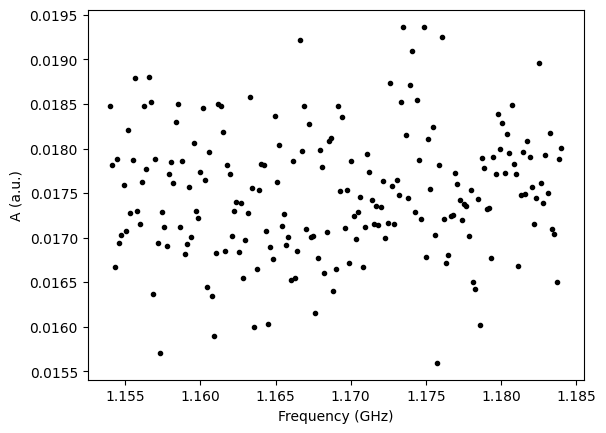

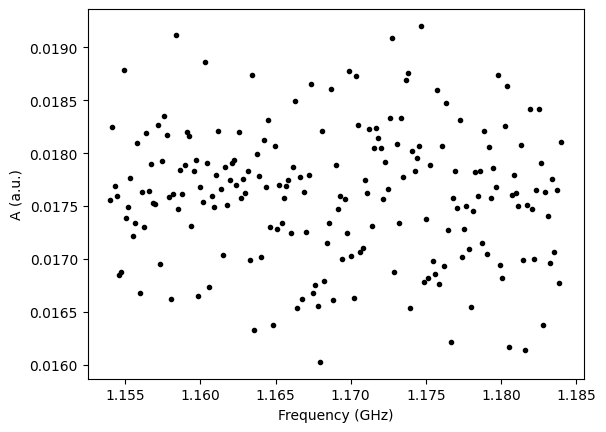

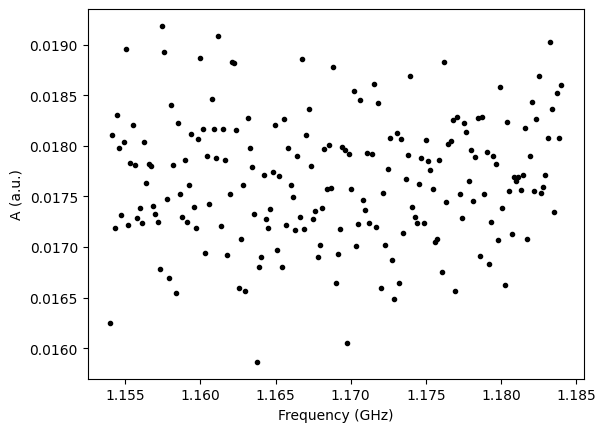

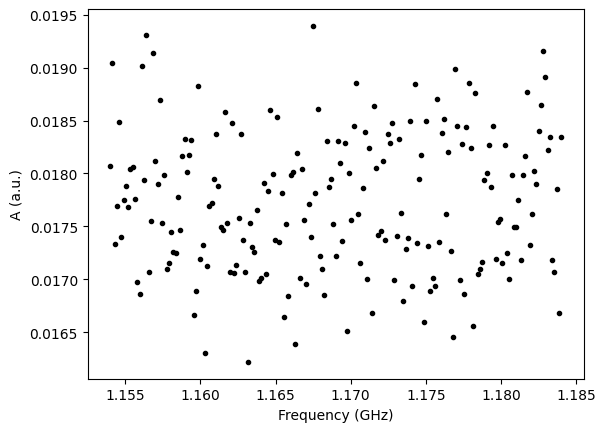

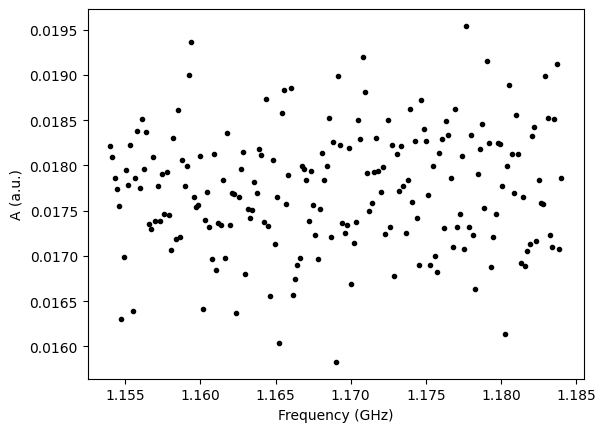

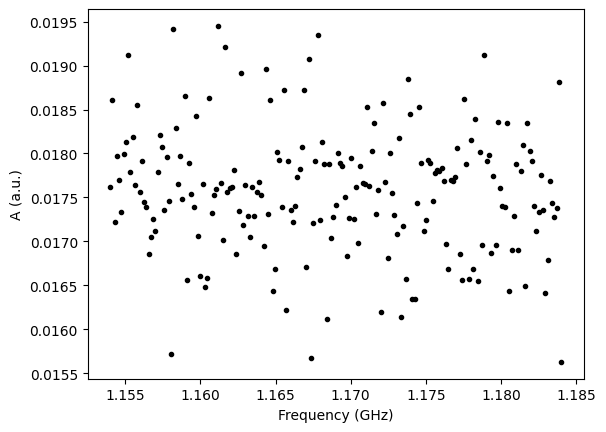

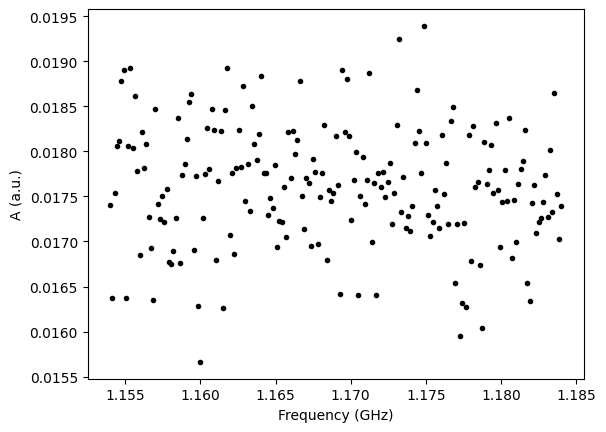

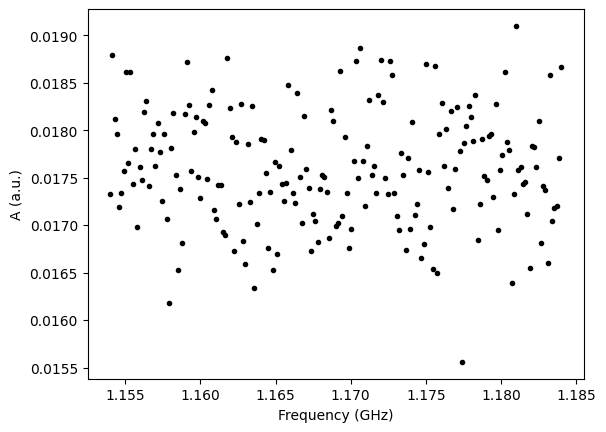

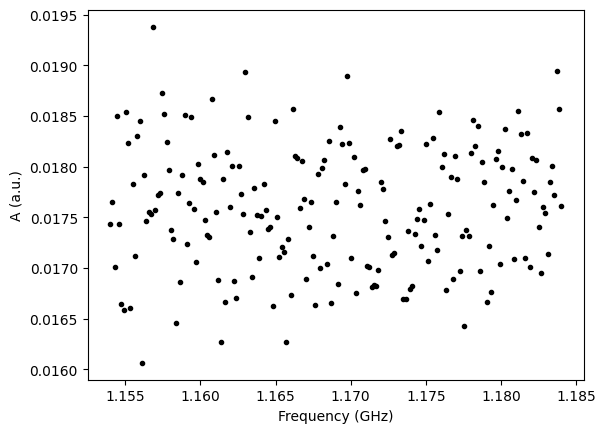

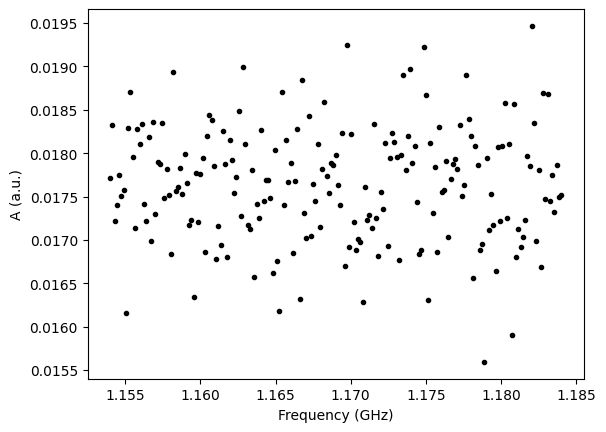

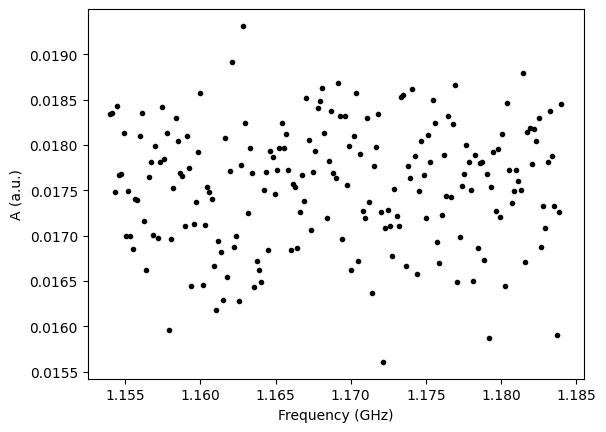

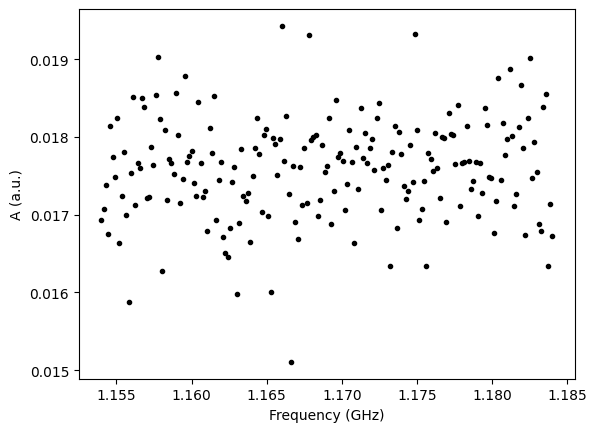

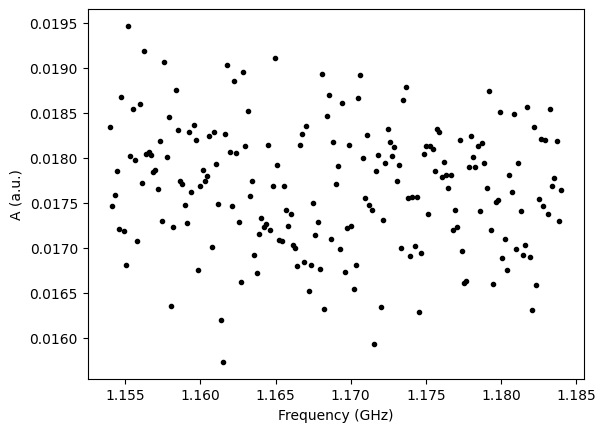

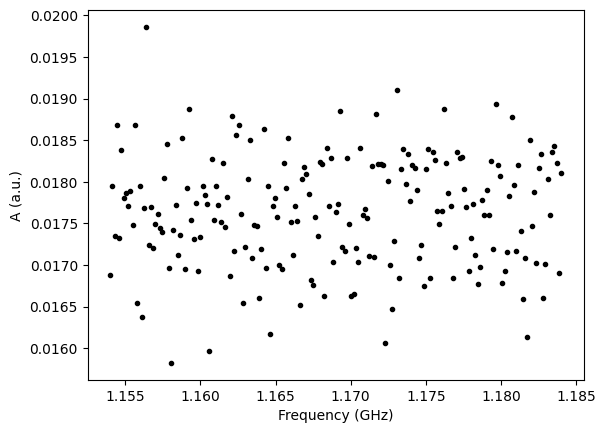

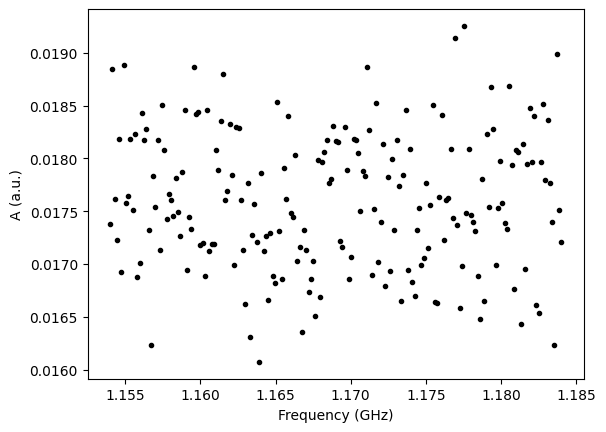

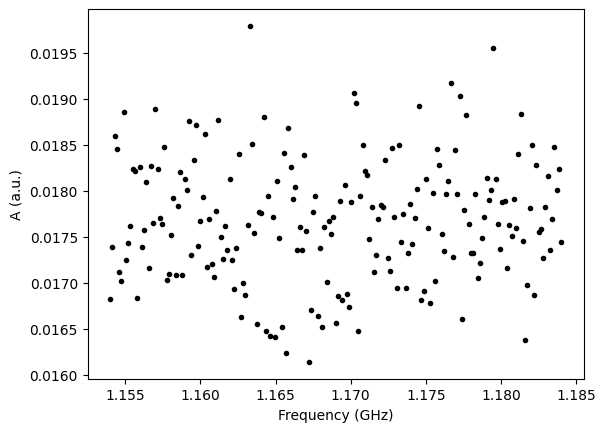

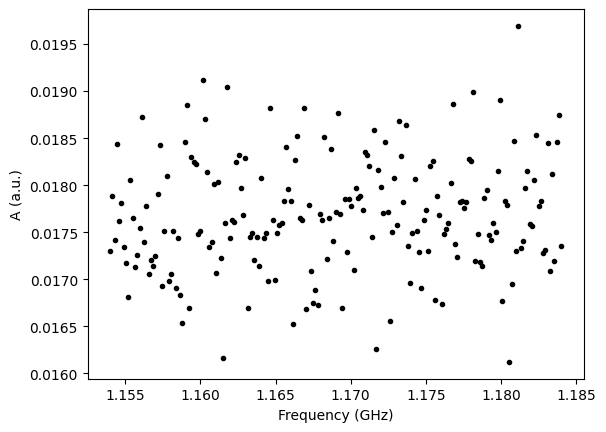

In [290]:
# dc.current_range(1e-3)
start = 8.7e-3
stop = 8.9e-3

current_sweep = np.linspace(start, stop, 21)
dc.output('on')
sweep_qspec_results = []
for current in current_sweep:
    dc.ramp_current(current, 1e-6, 0)
    time.sleep(0.5)
    # run the experiment on qubit 0
    qspec_results = session.run()

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    qspec_res = qspec_results.get_data("qb_spec")
    qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency
    sweep_qspec_results.append(qspec_res)

    # plot measurement data
    fig = plt.figure()
    plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
    plt.ylabel("A (a.u.)")
    plt.xlabel("Frequency (GHz)")

# plt.show()
# dc.ramp_current(5.5e-3,1e-5,0)

Text(0.5, 1.0, 'mag')

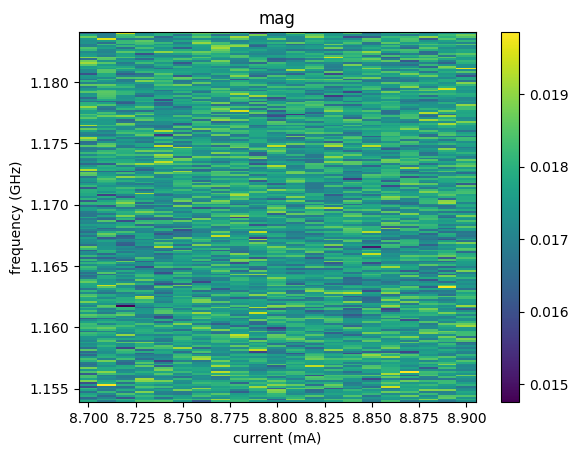

In [291]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.abs(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(6.2)
# current_sweep[8]*1e3

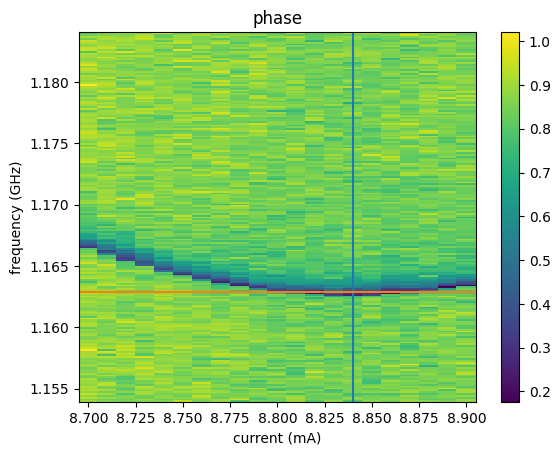

In [309]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.angle(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
plt.axvline(08.84)
plt.axhline(1.1629, color='tab:orange')
# current_sweep[8]*1e3

In [297]:
angle_data = np.angle(sweep_qspec_results).T
angle_data.shape

(201, 21)

In [298]:
min_arr = np.argmin(angle_data, axis=0)
min_arr.shape

(21,)

In [299]:
min_freqs = (qspec_freq/1e9)[min_arr]
min_freqs.shape

(21,)

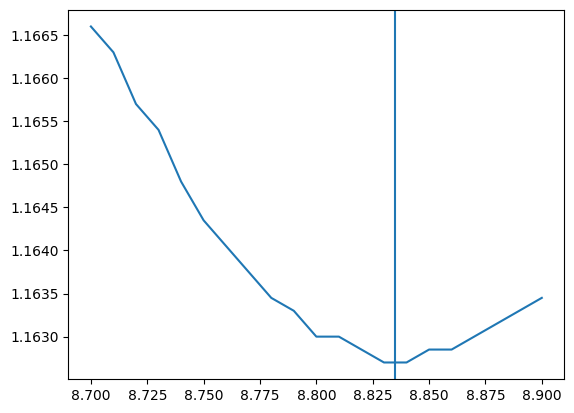

In [303]:
# plt.plot( current_sweep*1e3, min_arr)
plt.plot( current_sweep*1e3, min_freqs)
plt.axvline(8.835)

### 3.6 Amplitude Rabi Experiment

Sweep the pulse amplitude of a qubit drive pulse to determine the ideal amplitudes for specific qubit rotation angles

#### 3.6.1 Additional Experimental Parameters

Define the amplitude sweep range and qubit excitation pulse

In [1577]:
dc.ramp_current(8.835e-3, 1e-6, 0)

In [1796]:
# measure_q.parameters.resonance_frequency_ge = 1.191e9
measure_q.parameters.user_defined['reset_length'] = 100e-6
# measure_q.parameters.user_defined['reset_length'] = e-6

measure_q.parameters.user_defined['pulse_length'] = 2000e-9
# measure_q.parameters.user_defined['pulse_length'] = 5e-6

measure_q.parameters.user_defined['amplitude_pi'] = 0.99
measure_q.parameters.drive_range = 10
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1161000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6816000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [1809]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 14

# define number of amplitude points, from 0 to 1 in gain
num_amplitudes = 50
amp_min=0.4
amp_max=0.99
# amp_max=0.


#### 3.6.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [1810]:
def create_square_pulse(qubit):
    pulse = pulse_library.const(
        uid=f"square_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=1, #max power to start
        # amplitude=amp, #max power to start
    )

    return pulse

In [1811]:
# function that returns an amplitude Rabi experiment


def amplitude_rabi(drive_pulse, readout_pulse, amplitude_sweep, relax_time = 1e-6):
    exp_rabi = Experiment(
        uid="Amplitude Rabi",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        # inner loop - real time sweep of Rabi ampitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
            # play qubit excitation pulse - pulse amplitude is swept
            with exp_rabi.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_rabi.play(
                    signal="drive", pulse=drive_pulse, amplitude=amplitude_sweep, marker = {"marker1": {"enable": True}}
                )
            # readout pulse and data acquisition
            with exp_rabi.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_rabi.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rabi.acquire(
                    signal="acquire",
                    handle="amp_rabi",
                    kernel=readout_pulse,
                )
                
            with exp_rabi.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rabi.reserve(signal="measure")
    return exp_rabi

#### 3.6.3 Set Experiment Parameters and Compile

In [1812]:
def create_rabi_amp_sweep(qubit, amp_num, amp_min=0.1, amp_max=0.22, uid="rabi_amp"):
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

In [1813]:
# set signal map for qubit - no experimental calibration necessary, calibration taken from DeviceSetup, i.e. baseline
device_setup.set_calibration(
    measure_q.calibration()
)

drive_pulse = create_rabi_drive_pulse(measure_q)
# drive_pulse = create_drive_spec_pulse(measure_q)
# drive_pulse = create_square_pulse(measure_q)

exp_rabi = amplitude_rabi(
    drive_pulse, readout_pulse, create_rabi_amp_sweep(qubit=measure_q, amp_num=num_amplitudes, amp_min=amp_min, amp_max=amp_max), relax_time = measure_q.parameters.user_defined['reset_length']
)

exp_rabi.set_signal_map(signal_map_default(measure_q))

# compile the experiment on the open instrument session
compiled_rabi = session.compile(exp_rabi)

[2024.08.01 11:12:11.518] INFO    Starting LabOne Q Compiler run...
[2024.08.01 11:12:11.526] INFO    Schedule completed. [0.005 s]
[2024.08.01 11:12:11.575] INFO    Code generation completed for all AWGs. [0.048 s]
[2024.08.01 11:12:11.577] INFO    Completed compilation step 1 of 1. [0.056 s]
[2024.08.01 11:12:11.580] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 11:12:11.581] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 11:12:11.582] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 11:12:11.584] INFO      device_shfqc        0         11            0           1      8000  
[2024.08.01 11:12:11.585] INFO      device_shfqc_sg     0        158           50           1      8000  
[2024.08.01 11:12:11.587] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 11:12:11.588] INFO      TOTAL                        169 

#### 3.6.4 Show Pulse Sheet

In [1814]:
show_pulse_sheet("Pulse_Sheets/Amplitude_Rabi", compiled_rabi)

[2024.08.01 11:12:11.601] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.08.01 11:12:11.603] INFO    Starting LabOne Q Compiler run...
[2024.08.01 11:12:11.613] INFO    Schedule completed. [0.007 s]
[2024.08.01 11:12:11.655] INFO    Code generation completed for all AWGs. [0.041 s]
[2024.08.01 11:12:11.657] INFO    Completed compilation step 1 of 1. [0.051 s]
[2024.08.01 11:12:11.659] INFO    Finished LabOne Q Compiler run.
[2024.08.01 11:12:11.672] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-08-01-11-12-11.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-08-01-11-12-11.html

#### 3.6.5 Plot Simulated Outputs

In [1815]:
# Simulate experiment
# plot_simulation(compiled_rabi, 0e-6, 30e-6)

#### 3.6.6 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [1816]:
# run the compiled experiemnt
rabi_results = session.run(compiled_rabi)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/rabi_results_{timestamp}.json")
print(f"File saved as Results_Needed/rabi_results_{timestamp}.json")

[2024.08.01 11:12:11.719] INFO    Configuring the device setup
[2024.08.01 11:12:11.824] INFO    The device setup is configured
[2024.08.01 11:12:12.650] INFO    Starting near-time execution...
[2024.08.01 11:12:13.203] INFO    Estimated RT execution time: 85.20 s.
[2024.08.01 11:13:38.669] INFO    Finished near-time execution.
File saved as Results_Needed/rabi_results_20240801T111338.json


In [1817]:
# get measurement data returned by the instruments
rabi_res = rabi_results.get_data("amp_rabi")

# define amplitude axis from qubit parameters
rabi_amp = rabi_results.get_axis("amp_rabi")[0]

if emulate:
    # create some dummy data if running in emulation mode
    rabi_res = oscillatory(rabi_amp, 10, 0, 1, 1.2) + 0.2 * np.random.rand(
        len(rabi_amp)
    )

Text(0.5, 1.0, 'Resonator phase response')

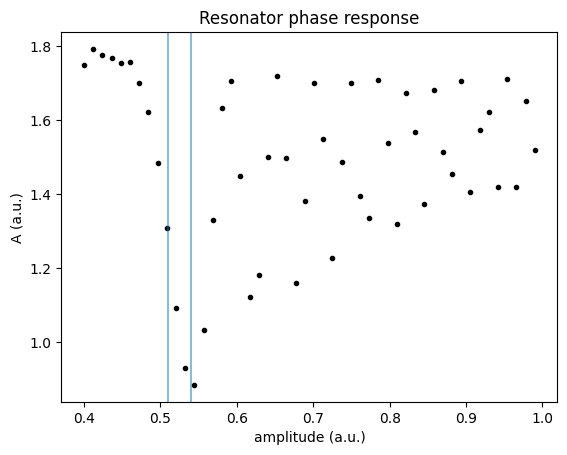

In [1823]:
# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, np.angle(rabi_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
# popt, pcov = oscillatory.fit(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
# print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
# plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
# plt.axvline(0.22)
pi_amp = (np.pi-(np.pi-popt[1]))/(popt[0])
plt.axvline(0.54, alpha=0.5)
plt.axvline(0.51, alpha=0.5)
# pi_amp = 0.95

plt.title('Resonator phase response')

Fitted parameters: [ 1.58919770e+04  1.79247918e+00 -6.33603212e-01]


Text(0.5, 1.0, 'Resonator mag response')

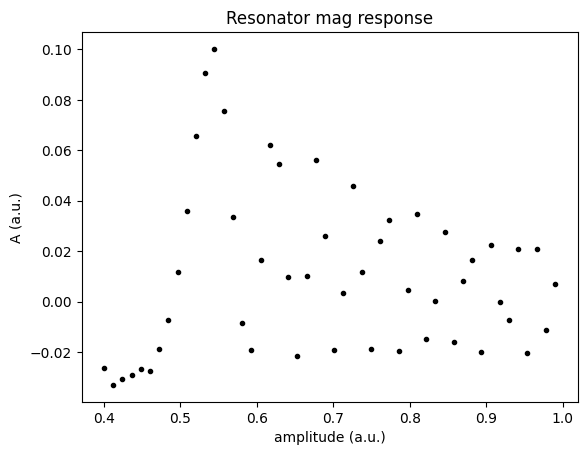

In [1819]:
# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, rabi_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
# popt, pcov = oscillatory.fit(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
# plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
# plt.axvline(0.22)
pi_amp = (np.pi-(np.pi-popt[1]))/(popt[0])
# plt.axvline(0.51, alpha=0.5)
# plt.axvline(0.28, alpha=0.5)
# pi_amp = 0.95

plt.title('Resonator mag response')

In [992]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1163000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6816000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=0,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.1,
│   │   │   'pulse_length': 4e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

Type:           Transmon
String form:    
File:           c:\users\qnlbe\.conda\envs\laboneq\lib\site-packages\laboneq\dsl\quantum\transmon.py
Docstring:      A class for a superconducting, flux-tuneable Transmon Qubit.
Init docstring:
Initializes a new Transmon Qubit.

Args:
    uid: A unique identifier for the Qubit.
    signals: A mapping of logical signals associated with the qubit.
        Qubit accepts the following keys in the mapping: 'drive', 'measure', 'acquire', 'flux'

        This is so that the Qubit parameters are assigned into the correct signal lines in
        calibration.
    parameters: Parameters associated with the qubit.
        Required for generating calibration and experiment signals via `calibration()` and `experiment_signals()`.

In [1824]:
# rabi_amplitude = pi_amp
measure_q.parameters.user_defined['amplitude_pi'] = 0.54
measure_q.parameters.user_defined['amplitude_pi/2'] = 0.51

# T1

#### 3.7.1 Experiment Parameters

In [1825]:
# measure_q.parameters.user_defined['amplitude_pi'] = 0.95
# measure_q.parameters.user_defined['pulse_length'] = 20e-6
# measure_q.parameters.drive_range = 10

In [1826]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1161000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6816000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.54,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0001,
│   │   │   'amplitude_pi/2': 0.51
│   │   }
│   )
)

In [1827]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define delay sweep
n_steps = 10
start_delay = 0e-6
stop_delay = 100e-6


#### 3.7.2 Experiment Definition

In [1828]:
# function that returns a T1 experiment


def T1(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_T1 = Experiment(
        uid="T1 Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define T1 experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_T1.acquire_loop_rt(
        uid="T1_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
        
        # inner loop - real time sweep of T1 time delays
        with exp_T1.sweep(
            uid="T1_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - delay is swept
            with exp_T1.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_T1.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_T1.delay(signal="drive", time=time_sweep)
            # readout pulse and data acquisition
            with exp_T1.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_T1.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_T1.acquire(
                    signal="acquire",
                    handle="T1",
                    kernel=readout_pulse,
                )
            with exp_T1.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_T1.reserve(signal="measure")
    return exp_T1

#### 3.7.3 Create Experiment and Signal Map

In [1829]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_T1_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

T1_exp = T1(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

T1_exp.set_signal_map(signal_map_default(measure_q))

compiled_T1 = session.compile(T1_exp)

[2024.08.01 11:17:38.110] INFO    Starting LabOne Q Compiler run...
[2024.08.01 11:17:38.114] INFO    Schedule completed. [0.001 s]
[2024.08.01 11:17:38.128] INFO    Code generation completed for all AWGs. [0.013 s]
[2024.08.01 11:17:38.130] INFO    Completed compilation step 1 of 1. [0.017 s]
[2024.08.01 11:17:38.133] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 11:17:38.134] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 11:17:38.136] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 11:17:38.137] INFO      device_shfqc        0         49            0           1      8000  
[2024.08.01 11:17:38.138] INFO      device_shfqc_sg     0         76            9           9     72256  
[2024.08.01 11:17:38.139] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 11:17:38.140] INFO      TOTAL                        125 

#### 3.7.4 Show Pulse Sheet

In [1830]:
show_pulse_sheet("Pulse_Sheets/T1", compiled_T1)

[2024.08.01 11:17:38.150] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.08.01 11:17:38.152] INFO    Starting LabOne Q Compiler run...
[2024.08.01 11:17:38.158] INFO    Schedule completed. [0.004 s]
[2024.08.01 11:17:38.171] INFO    Code generation completed for all AWGs. [0.012 s]
[2024.08.01 11:17:38.173] INFO    Completed compilation step 1 of 1. [0.019 s]
[2024.08.01 11:17:38.175] INFO    Finished LabOne Q Compiler run.
[2024.08.01 11:17:38.189] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-08-01-11-17-38.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-08-01-11-17-38.html

#### 3.7.5 Plot Simulated Outputs

In [1831]:
# plot_simulation(compiled_T1, 100e-6, 150e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [1832]:
# run the compiled experiemnt
T1_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/T1_results_{timestamp}.json")
print(f"File saved as Results_Needed/T1_results_{timestamp}.json")

[2024.08.01 11:17:38.234] INFO    Configuring the device setup
[2024.08.01 11:17:38.342] INFO    The device setup is configured
[2024.08.01 11:17:39.151] INFO    Starting near-time execution...
[2024.08.01 11:17:39.726] INFO    Estimated RT execution time: 12.62 s.
[2024.08.01 11:17:52.676] INFO    Finished near-time execution.
File saved as Results_Needed/T1_results_20240801T111752.json


In [1833]:
# get measurement data returned by the instruments
T1_res = T1_results.get_data("T1")

# define time axis from qubit parameters
T1_delay = T1_results.get_axis("T1")[0]

if emulate:
    # create dummy data if running in emulation mode
    T1_res = exponential_decay(
        T1_delay, 2e5, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(T1_delay))

Text(0.5, 0, 'delay (us)')

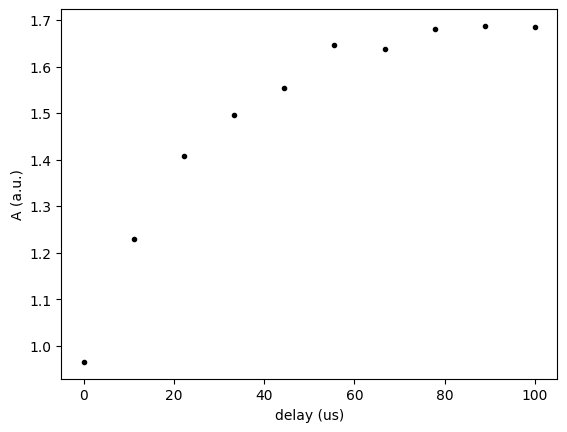

In [1834]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay*1e6, np.angle(T1_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

Text(0.5, 0, 'delay (us)')

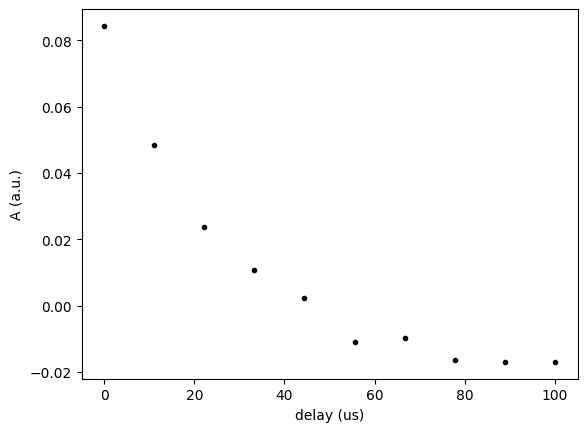

In [1835]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay*1e6, T1_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

Fitted parameters: [ 3.74683585e+04 -2.02868432e-02  1.04317464e-01]
T1 time 26.689186271798423 us


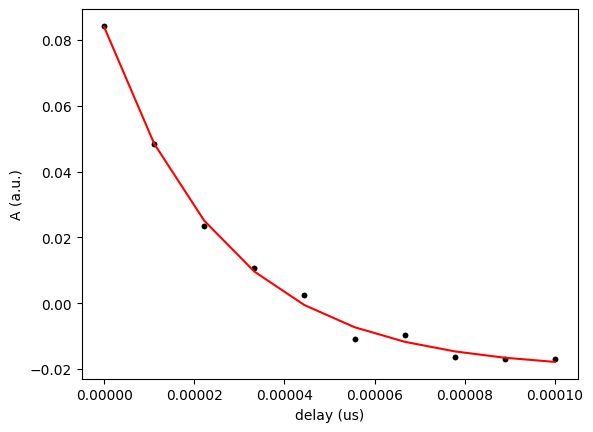

In [1836]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay, T1_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

# increase number of plot points for smooth plotting of fit results
#delay_plot = np.linspace(T1_delay[0], T1_delay[-1], 5 * len(T1_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = exponential_decay.fit(
   T1_delay,
   T1_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T1 time ' + str(1/popt[0]*1e6) + ' us') 
# plot fit results together with experimental data
#plt.plot(delay_plot, oscillatory_decay(delay_plot, *popt), "-r");

### 3.7 Ramsey Experiment
The Ramsey experiment is different from the experiments above as the length of the drive section changes. Using a right-aligned sweep section and the automatic repetition time makes sure that the experiment is run as efficiently as possible on the Zurich Instruments hardware.

#### 3.7.1 Experiment Parameters

In [1944]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

# define delay sweep
n_steps = 121
start_delay = 0e-6
stop_delay = 3e-6


#### 3.7.2 Experiment Definition

In [1945]:
def create_ramsey_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi/2'],
    )

In [1946]:
# function that returns a Ramsey experiment


def ramsey(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_ramsey = Experiment(
        uid="Ramsey Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey.sweep(
            uid="ramsey_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - pulse delay is swept
            with exp_ramsey.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_ramsey.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_ramsey.delay(signal="drive", time=time_sweep)
                exp_ramsey.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_ramsey.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_ramsey.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_ramsey.acquire(
                    signal="acquire",
                    handle="ramsey",
                    kernel=readout_pulse,
                )
            with exp_ramsey.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_ramsey.reserve(signal="measure")
    return exp_ramsey

In [1947]:
# #measure_q.parameters.user_defined['reset_length'] = 1e-3
# measure_q.parameters.resonance_frequency_ge = measure_q.parameters.resonance_frequency_ge
# print(measure_q)

#### 3.7.3 Create Experiment and Signal Map

In [1948]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_ramsey_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

ramsey_exp = ramsey(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

ramsey_exp.set_signal_map(signal_map_default(measure_q))

compiled_ramsey = session.compile(ramsey_exp)

[2024.08.01 11:58:02.679] INFO    Starting LabOne Q Compiler run...
[2024.08.01 11:58:02.695] INFO    Schedule completed. [0.013 s]
[2024.08.01 11:58:02.810] INFO    Code generation completed for all AWGs. [0.113 s]
[2024.08.01 11:58:02.812] INFO    Completed compilation step 1 of 1. [0.130 s]
[2024.08.01 11:58:02.816] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 11:58:02.817] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 11:58:02.819] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 11:58:02.820] INFO      device_shfqc        0        489            0           1      8000  
[2024.08.01 11:58:02.821] INFO      device_shfqc_sg     0        635            9           9     72352  
[2024.08.01 11:58:02.823] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 11:58:02.824] INFO      TOTAL                       1124 

#### 3.7.4 Show Pulse Sheet

In [1949]:
show_pulse_sheet("Pulse_Sheets/Ramsey", compiled_ramsey)

[2024.08.01 11:58:02.834] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.08.01 11:58:02.837] INFO    Starting LabOne Q Compiler run...
[2024.08.01 11:58:02.855] INFO    Schedule completed. [0.017 s]
[2024.08.01 11:58:02.962] INFO    Code generation completed for all AWGs. [0.104 s]
[2024.08.01 11:58:02.963] INFO    Completed compilation step 1 of 1. [0.125 s]
[2024.08.01 11:58:02.965] INFO    Finished LabOne Q Compiler run.
[2024.08.01 11:58:02.979] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Ramsey_2024-08-01-11-58-02.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Ramsey_2024-08-01-11-58-02.html

#### 3.7.5 Plot Simulated Outputs

In [1950]:
# plot_simulation(compiled_ramsey, 50e-6, 100e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [1951]:
# run the compiled experiemnt
ramsey_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/ramsey_results_{timestamp}_.json")
print(f"File saved as Results/ramsey_results_{timestamp}_.json")

[2024.08.01 11:58:03.019] INFO    Configuring the device setup
[2024.08.01 11:58:03.121] INFO    The device setup is configured
[2024.08.01 11:58:03.735] INFO    Starting near-time execution...
[2024.08.01 11:58:04.274] INFO    Estimated RT execution time: 53.28 s.
[2024.08.01 11:58:57.830] INFO    Finished near-time execution.
File saved as Results/ramsey_results_20240801T115857_.json


In [1952]:
# get measurement data returned by the instruments
ramsey_res = ramsey_results.get_data("ramsey")

# define time axis from qubit parameters
ramsey_delay = ramsey_results.get_axis("ramsey")[0]

if emulate:
    # create dummy data if running in emulation mode
    ramsey_res = oscillatory_decay(
        ramsey_delay, 1e6, 0, 1 / 10e-6, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(ramsey_delay))

Fitted parameters: [ 6.03699576e+07 -9.10265088e+00  2.31606933e+05  2.09908026e-01
  1.43856488e+00]


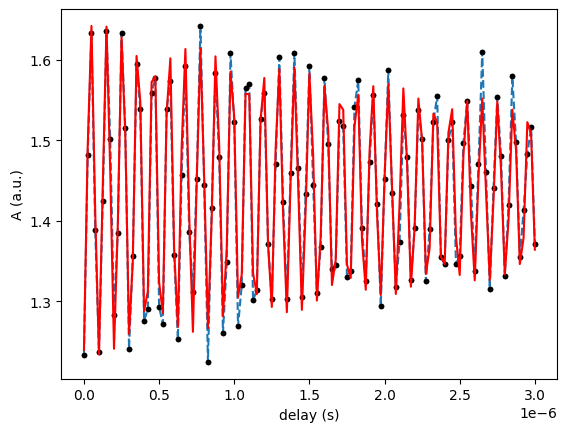

In [1953]:
# plot measurement results
fig = plt.figure()
plt.plot(ramsey_delay, np.angle(ramsey_res), ".k")
plt.plot(ramsey_delay, np.angle(ramsey_res), linestyle ='--')

plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(ramsey_delay[0], ramsey_delay[-1], 5 * len(ramsey_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    ramsey_delay,
    np.angle(ramsey_res),
    10/0.5e-6,
    0,
    1 / 4e-6,
    0.002,
    0.0008,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

In [1954]:
print(f'detuning = {popt[0]*1e-6} MHz, T2r = {1e6/popt[2]} us')

detuning = 60.36995755798465 MHz, T2r = 4.317660036928392 us


In [1922]:
# measure_q.parameters.resonance_frequency_ge = measure_q.parameters.resonance_frequency_ge + 0.5e6

In [1939]:
measure_q.parameters.resonance_frequency_ge

1160700000.0

In [1937]:
measure_q.parameters.resonance_frequency_ge = 1.1607e9

In [1938]:
device_setup.set_calibration(
    measure_q.calibration()
)

### 3.9 echo Experiment
Adding a Y180 pulse in middle of Ramsey

In [1566]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 14

# define delay sweep
n_steps = 31
start_delay = 0e-6
stop_delay = 200e-6


#### 3.9.2 Experiment Definition

In [1567]:
# function that returns an Echo experiment


def echo(x90_pulse, y180_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_echo = Experiment(
        uid="Echo Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Echo experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_echo.acquire_loop_rt(
        uid="echo_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of echo time delays
        with exp_echo.sweep(
            uid="echo_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse
            with exp_echo.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_echo.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
                exp_echo.delay(signal="drive", time=time_sweep/2)
                exp_echo.play(signal="drive", pulse=y180_pulse, phase = 0, marker = {"marker1": {"enable": True}})
                exp_echo.delay(signal="drive", time=time_sweep/2)
                exp_echo.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_echo.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_echo.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_echo.acquire(
                    signal="acquire",
                    handle="echo",
                    kernel=readout_pulse,
                )
            with exp_echo.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_echo.reserve(signal="measure")
    return exp_echo

In [1568]:
# measure_q.parameters.resonance_frequency_ge = 4.5509e9+190e3
# measure_q.parameters.user_defined['reset_length'] = 5e-3
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1160700000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6816000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=5,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 4e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

#### 3.9.3 Create Experiment and Signal Map

In [1569]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
x90_pulse = create_pi_2_pulse(measure_q)
y180_pulse = create_pi_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

echo_exp = echo(
    x90_pulse=x90_pulse, y180_pulse=y180_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

echo_exp.set_signal_map(signal_map_default(measure_q))

compiled_echo = session.compile(echo_exp)

[2024.08.01 09:47:54.081] INFO    Starting LabOne Q Compiler run...
[2024.08.01 09:47:54.087] INFO    Schedule completed. [0.004 s]
[2024.08.01 09:47:54.124] INFO    Code generation completed for all AWGs. [0.035 s]
[2024.08.01 09:47:54.126] INFO    Completed compilation step 1 of 1. [0.043 s]
[2024.08.01 09:47:54.129] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 09:47:54.130] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.08.01 09:47:54.131] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 09:47:54.133] INFO      device_shfqc        0        177            0           1      8000  
[2024.08.01 09:47:54.134] INFO      device_shfqc_sg     0        260            6           6     96128  
[2024.08.01 09:47:54.135] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.08.01 09:47:54.136] INFO      TOTAL                        437 

#### 3.9.4 Show Pulse Sheet

In [1570]:
show_pulse_sheet("Pulse_Sheets/echo", compiled_echo)

[2024.08.01 09:47:54.146] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.08.01 09:47:54.149] INFO    Starting LabOne Q Compiler run...
[2024.08.01 09:47:54.158] INFO    Schedule completed. [0.007 s]
[2024.08.01 09:47:54.196] INFO    Code generation completed for all AWGs. [0.036 s]
[2024.08.01 09:47:54.197] INFO    Completed compilation step 1 of 1. [0.046 s]
[2024.08.01 09:47:54.199] INFO    Finished LabOne Q Compiler run.
[2024.08.01 09:47:54.215] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\echo_2024-08-01-09-47-54.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\echo_2024-08-01-09-47-54.html

#### 3.9.5 Plot Simulated Outputs

In [1571]:
# plot_simulation(compiled_echo, 4000e-6, 4050e-6, plot_width=10)

#### 3.9.6 Run, Save, and Plot Results

In [1572]:
# run the compiled experiemnt
echo_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/echo_results_{timestamp}.json")
print(f"File saved as Results/echo_results_{timestamp}.json")

[2024.08.01 09:47:54.262] INFO    Configuring the device setup
[2024.08.01 09:47:54.376] INFO    The device setup is configured
[2024.08.01 09:47:55.101] INFO    Starting near-time execution...
[2024.08.01 09:47:55.630] INFO    Estimated RT execution time: 108.69 s.
[2024.08.01 09:49:44.592] INFO    Finished near-time execution.
File saved as Results/echo_results_20240801T094944.json


In [1573]:
# get measurement data returned by the instruments
echo_res = echo_results.get_data("echo")

# define time axis from qubit parameters
echo_delay = echo_results.get_axis("echo")[0]


Fitted parameters: [ 1.50861990e+04 -3.51809551e-02  9.54287238e-02]
T2e time 66.2857489293286 us


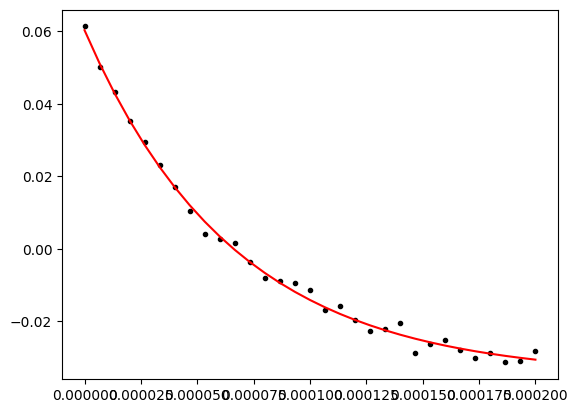

In [1574]:
popt, pcov = exponential_decay.fit(
   echo_delay,
   echo_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 

Fitted parameters: [ 1.50861990e+04 -3.51809551e-02  9.54287238e-02]
T2e time 66.2857489293286 us


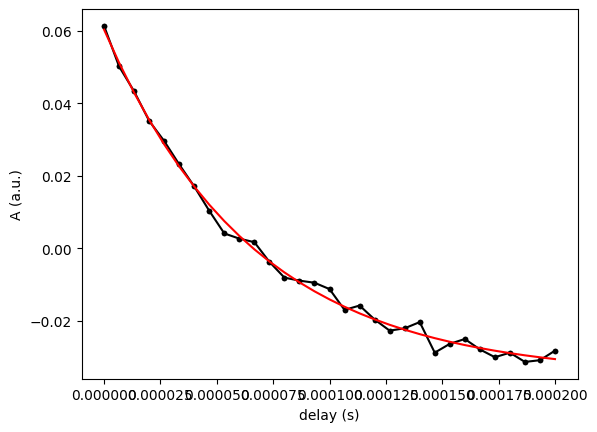

In [1575]:
# plot measurement results (XXX) 5 ms reset
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel(r"delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

popt, pcov = exponential_decay.fit(
   echo_delay,
   echo_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 

Fitted parameters: [ 1.58919770e+04  1.79247918e+00 -6.33603212e-01]
T2e time 62.92483324416482 us


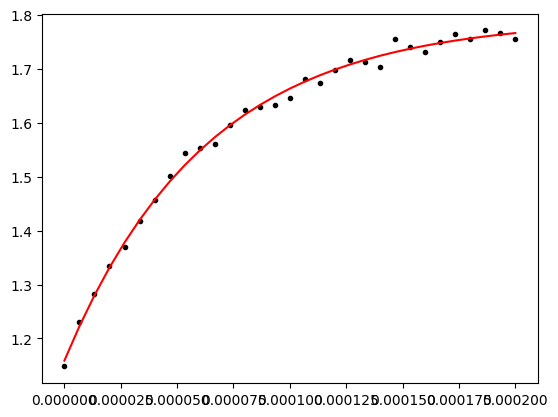

In [1576]:
popt, pcov = exponential_decay.fit(
   echo_delay,
   np.angle(echo_res),
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 

# Single-qubit gates

In [1498]:
measure_q.parameters.drive_range = -25

device_setup.set_calibration(
    measure_q.calibration()
)

In [1476]:
measure_q.parameters.resonance_frequency_ge = 0.967e9
measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['pulse_length'] = 2000e-9
measure_q.parameters.user_defined['amplitude_pi'] = 0.99
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-30,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [1477]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define number of amplitude points, from 0 to 1 in gain
num_amplitudes = 20
amp_min=0.0
amp_max=0.99


#### 3.6.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [1478]:
# function that returns an amplitude Rabi experiment


def amplitude_rabi(drive_pulse, readout_pulse, amplitude_sweep, relax_time = 1e-6):
    exp_rabi = Experiment(
        uid="Amplitude Rabi",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        # inner loop - real time sweep of Rabi ampitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
            # play qubit excitation pulse - pulse amplitude is swept
            with exp_rabi.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_rabi.play(
                    signal="drive", pulse=drive_pulse, amplitude=amplitude_sweep, marker = {"marker1": {"enable": True}}
                )
            # readout pulse and data acquisition
            with exp_rabi.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_rabi.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rabi.acquire(
                    signal="acquire",
                    handle="amp_rabi",
                    kernel=readout_pulse,
                )
            with exp_rabi.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rabi.reserve(signal="measure")
    return exp_rabi

#### 3.6.3 Set Experiment Parameters and Compile

In [1479]:
def create_rabi_amp_sweep(qubit, amp_num, amp_min=0.1, amp_max=0.22, uid="rabi_amp"):
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

In [1480]:
# set signal map for qubit - no experimental calibration necessary, calibration taken from DeviceSetup, i.e. baseline
device_setup.set_calibration(
    measure_q.calibration()
)

drive_pulse = create_rabi_drive_pulse(measure_q)

exp_rabi = amplitude_rabi(
    drive_pulse, readout_pulse, create_rabi_amp_sweep(qubit=measure_q, amp_num=num_amplitudes, amp_min=amp_min, amp_max=amp_max), relax_time = measure_q.parameters.user_defined['reset_length']
)

exp_rabi.set_signal_map(signal_map_default(measure_q))

# compile the experiment on the open instrument session
compiled_rabi = session.compile(exp_rabi)

[2024.07.30 11:52:31.766] INFO    Starting LabOne Q Compiler run...
[2024.07.30 11:52:31.771] INFO    Schedule completed. [0.002 s]
[2024.07.30 11:52:31.798] INFO    Code generation completed for all AWGs. [0.026 s]
[2024.07.30 11:52:31.800] INFO    Completed compilation step 1 of 1. [0.032 s]
[2024.07.30 11:52:31.806] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:52:31.808] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 11:52:31.809] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:52:31.810] INFO      device_shfqc        0         11            0           1      8000  
[2024.07.30 11:52:31.812] INFO      device_shfqc_sg     0         71           20           2     16000  
[2024.07.30 11:52:31.813] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 11:52:31.814] INFO      TOTAL                         82 

#### 3.6.4 Show Pulse Sheet

In [1481]:
show_pulse_sheet("Pulse_Sheets/Amplitude_Rabi", compiled_rabi)

[2024.07.30 11:52:31.829] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 11:52:31.832] INFO    Starting LabOne Q Compiler run...
[2024.07.30 11:52:31.842] INFO    Schedule completed. [0.008 s]
[2024.07.30 11:52:31.863] INFO    Code generation completed for all AWGs. [0.019 s]
[2024.07.30 11:52:31.864] INFO    Completed compilation step 1 of 1. [0.030 s]
[2024.07.30 11:52:31.866] INFO    Finished LabOne Q Compiler run.
[2024.07.30 11:52:31.892] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-30-11-52-31.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-30-11-52-31.html

#### 3.6.5 Plot Simulated Outputs

In [1482]:
# Simulate experiment
# plot_simulation(compiled_rabi, 0e-6, 30e-6)

#### 3.6.6 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [1483]:
# run the compiled experiemnt
rabi_results = session.run(compiled_rabi)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/rabi_results_{timestamp}.json")
print(f"File saved as Results_Needed/rabi_results_{timestamp}.json")

[2024.07.30 11:52:48.114] INFO    Configuring the device setup
[2024.07.30 11:52:48.219] INFO    The device setup is configured
[2024.07.30 11:52:49.120] INFO    Starting near-time execution...
[2024.07.30 11:52:49.677] INFO    Estimated RT execution time: 17.04 s.
[2024.07.30 11:53:07.052] INFO    Finished near-time execution.
File saved as Results_Needed/rabi_results_20240730T115307.json


In [1484]:
# get measurement data returned by the instruments
rabi_res = rabi_results.get_data("amp_rabi")

# define amplitude axis from qubit parameters
rabi_amp = rabi_results.get_axis("amp_rabi")[0]

if emulate:
    # create some dummy data if running in emulation mode
    rabi_res = oscillatory(rabi_amp, 10, 0, 1, 1.2) + 0.2 * np.random.rand(
        len(rabi_amp)
    )

Fitted parameters: [ 1.18689038e+01 -1.22667517e+00  8.36838777e-04 -1.51922635e-02]


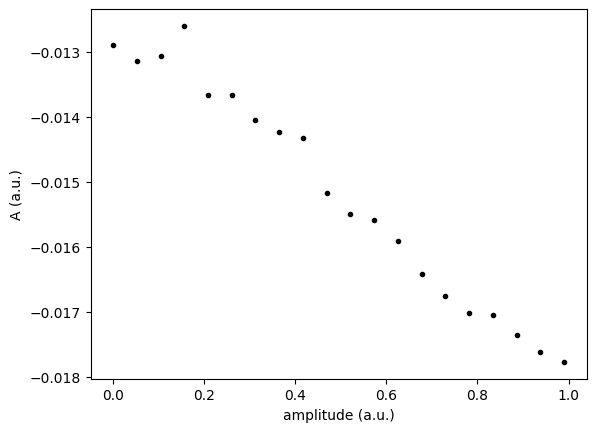

In [1485]:
# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, rabi_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
popt, pcov = oscillatory.fit(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
# plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
# plt.axvline(0.22)
pi_amp = (np.pi-(np.pi-popt[1]))/(popt[0])
# plt.axvline(0.55)
# pi_amp = 0.95

In [1486]:
# rabi_amplitude = pi_amp
measure_q.parameters.user_defined['amplitude_pi'] = 0.99

# On-chip flux line

## Resonator vs flux 

### resonator spectroscopy setup

In [1525]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -10e6
stop_freq = 10e6
num_points = 71

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 10

readout_pulse = create_readout_pulse(measure_q)

In [1526]:
2**10

1024

In [1527]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-25,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.51,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

#### 3.2.2 Experiment Definition

In [1528]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [1529]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [1530]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [1531]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.07.30 13:23:53.176] INFO    Starting LabOne Q Compiler run...
[2024.07.30 13:23:53.189] INFO    Schedule completed. [0.010 s]
[2024.07.30 13:23:53.214] INFO    Code generation completed for all AWGs. [0.023 s]
[2024.07.30 13:23:53.216] INFO    Completed compilation step 1 of 1. [0.036 s]
[2024.07.30 13:23:53.219] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 13:23:53.220] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 13:23:53.221] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 13:23:53.222] INFO      device_shfqc     0         23            0           1      8000  
[2024.07.30 13:23:53.224] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 13:23:53.225] INFO      TOTAL                      23            0                  8000  
[2024.07.30 13:23:53.226] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-07-30-13-23-53.html

#### 3.2.4 Run and Evaluate Experiment

In [1532]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.07.30 13:23:58.185] INFO    Configuring the device setup
[2024.07.30 13:23:58.289] INFO    The device setup is configured
[2024.07.30 13:23:59.356] INFO    Starting near-time execution...
[2024.07.30 13:24:01.057] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T132401.json


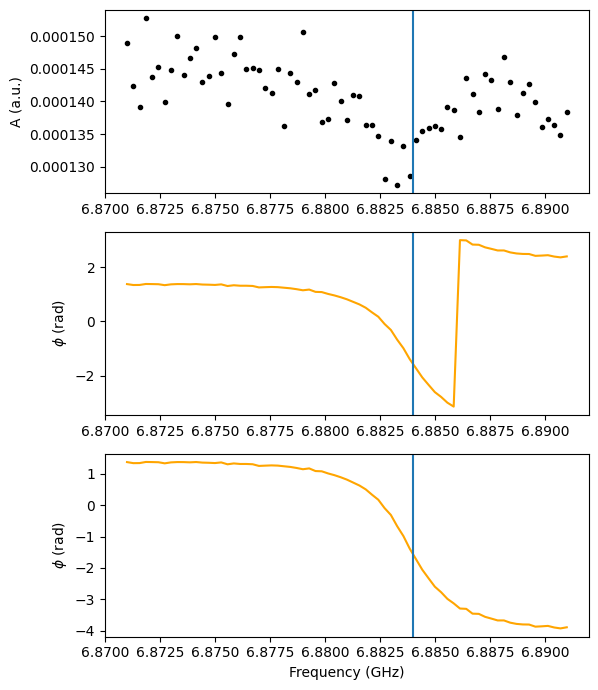

In [1539]:
electrical_delay = 60.68e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.8840]
for _vl in vl:
    ax1.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax2.axvline(_vl, ls='-', 
                # color='tab:blue',
               )
    ax3.axvline(_vl, ls='-', 
                # color='tab:blue',
               )

plt.tight_layout()
plt.show()

### f_r vs phi ext

In [365]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.02s


KeyError: 'Another instrument has the name: yoko'

In [237]:
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)

In [238]:
dc.output('off')
dc.source_mode('CURR')

In [1524]:
dc.ramp_current(0e-3, 0.5e-6,0)

In [239]:
dc.output('on')
dc.ramp_current(0.1e-3, 0.5e-6,0)
dc.ramp_current(0.0e-3, 0.5e-6,0)

In [1007]:
import sys

In [1540]:
plot = False  # plot individual resonator spectroscopy
dc.current_range(10e-3)

start_curr = 0e-3
stop_curr = 10e-3
current_sweep = np.linspace(start_curr,stop_curr, 101)

dc.ramp_current(0e-3, 1e-6, 0)

dc.output('off')
dc.source_mode('CURR')

dc.output('on')
sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc.ramp_current(current, 0.5e-6, 0)

    # debugging
    # dc.ramp_current(0e-3, 1e-6,0)
    # dc.output('off')
    # sys.exit()
    # time.sleep(0.5)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

# dc.ramp_current(0,0.5e-6,0)
# dc.output('off')

step 0
current: 0.0
[2024.07.30 13:27:25.443] INFO    Configuring the device setup
[2024.07.30 13:27:25.560] INFO    The device setup is configured
[2024.07.30 13:27:26.824] INFO    Starting near-time execution...
[2024.07.30 13:27:28.388] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T132728.json
step 1
current: 0.0001
[2024.07.30 13:27:30.675] INFO    Starting near-time execution...
[2024.07.30 13:27:32.262] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T132732.json
step 2
current: 0.0002
[2024.07.30 13:27:34.535] INFO    Starting near-time execution...
[2024.07.30 13:27:36.134] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240730T132736.json
step 3
current: 0.00030000000000000003
[2024.07.30 13:27:38.447] INFO    Starting near-time execution...
[2024.07.30 13:27:40.125] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pul

Text(0.5, 1.0, 'LogMag [arb.]')

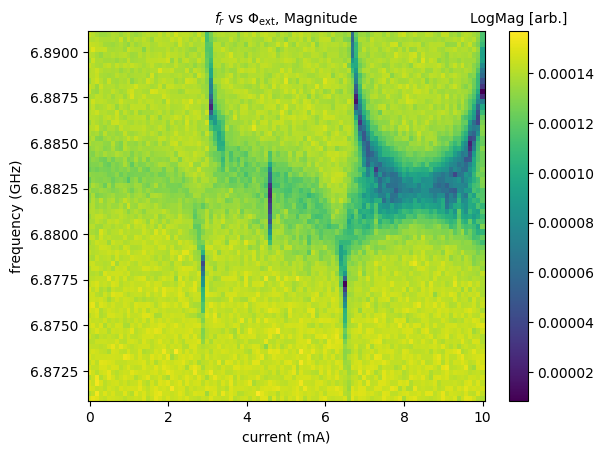

In [1541]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Magnitude', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

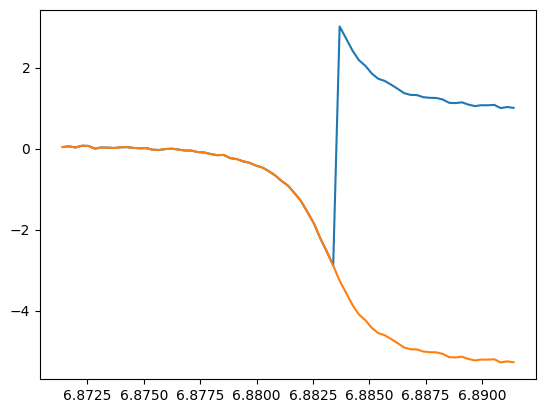

In [1129]:
electrical_delay = 60.65e-9
plt.plot(spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results[0]).T)
plt.plot(spec_freq/1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results[0]).T))

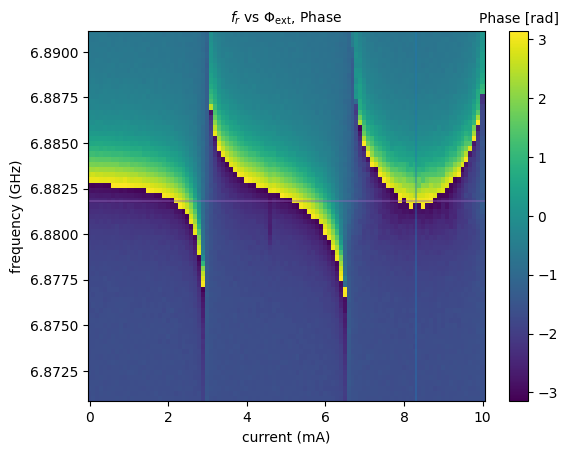

In [1548]:
electrical_delay = 60.61e-9
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(8.3, c='tab:blue', alpha=0.4)
plt.axhline(6.8818, c='tab:purple', alpha=0.4)

In [1577]:
dc.ramp_current(8.3e-3, 0.5e-6, 0)

# Two-tone

In [1416]:
dc.output('on')

In [1770]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
# qspec_num = 1001
qspec_num = 101

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 11

In [1771]:
### QB spec
measure_q.parameters.drive_lo_frequency = 1.3e9

LF_path = False
start_freq = -20e6
stop_freq = 20e6
measure_q.parameters.resonance_frequency_ge = 0.9721e9
# measure_q.parameters.user_defined['amplitude_pi'] = 0.99
measure_q.parameters.user_defined['amplitude_pi'] = 0.1

### RO spec
measure_q.parameters.readout_resonator_frequency = 6.881e9
# measure_q.parameters.readout_range_out = -10
# measure_q.parameters.readout_range_in = -15
# measure_q.parameters.user_defined['readout_amp'] = 0.3


# measure_q.parameters.drive_lo_frequency = 7.5e9
# measure_q.parameters.resonance_frequency_ge = 7.5e9

# measure_q.parameters.drive_range = 5
measure_q.parameters.drive_range = -25
measure_q.parameters.user_defined['reset_length'] = 1e-6
# measure_q.parameters.user_defined['pulse_length'] = 1000e-09
measure_q.parameters.user_defined['pulse_length'] = 2000e-09

# measure_q.parameters.user_defined['readout_range_out'] = -10
# measure_q.parameters.user_defined['readout_range_in'] = -10

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=972100000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-25,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.1,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15,
│   │   │   'amplitude_pi/2': 0.33
│   │   }
│   )
)

In [1772]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [1773]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [1774]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [1775]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [1776]:
measure_q.parameters.user_defined['reset_length'], freq_sweep_q, drive_pulse, readout_pulse

(1e-06,
 LinearSweepParameter(uid='drive_freq_q0', start=-347900000.0, stop=-307900000.0, count=101, axis_name=None),
 PulseFunctional(function='const', uid='drive_spec_pulse_q0', amplitude=0.95, length=2e-06, can_compress=False, pulse_parameters=None),
 PulseFunctional(function='gaussian_square', uid='readout_pulse_q0', amplitude=0.05, length=2e-06, can_compress=False, pulse_parameters={'width': 1.8e-06, 'sigma': 0.2}))

In [1777]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.07.30 14:58:03.026] INFO    Starting LabOne Q Compiler run...
[2024.07.30 14:58:03.039] INFO    Schedule completed. [0.011 s]
[2024.07.30 14:58:03.112] INFO    Code generation completed for all AWGs. [0.071 s]
[2024.07.30 14:58:03.114] INFO    Completed compilation step 1 of 1. [0.086 s]
[2024.07.30 14:58:03.117] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 14:58:03.119] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 14:58:03.120] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 14:58:03.121] INFO      device_shfqc        0         10            0           1      8000  
[2024.07.30 14:58:03.122] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.07.30 14:58:03.124] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 14:58:03.125] INFO      TOTAL                         32 

In [1778]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.07.30 14:58:03.135] INFO    Configuring the device setup
[2024.07.30 14:58:03.243] INFO    The device setup is configured
[2024.07.30 14:58:04.165] INFO    Starting near-time execution...
[2024.07.30 14:58:06.023] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T145806.json


In [1779]:
emulate=False

estimated frequency 0.9729 GHz


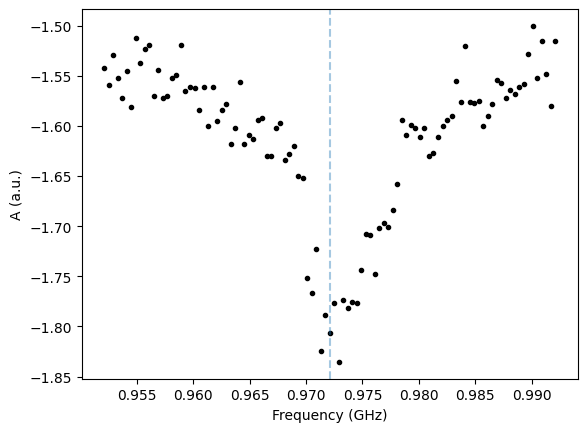

In [1780]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.angle(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

plt.axvline(0.9721, linestyle = '--', alpha=0.4)
# plt.axvline(1.160, linestyle = '--', alpha=0.4, color='tab:purple')
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmin(np.angle(qspec_res))]/1e9) + ' GHz')
plt.show()

In [1781]:
measure_q.parameters.resonance_frequency_ge = 0.9721e9
device_setup.set_calibration(
    measure_q.calibration()
)

In [1629]:
device_setup.set_calibration(
    measure_q.calibration()
)

In [1759]:
dc.ramp_current(8.3e-3, 1e-6, 0)

## Two-tone vs flux
Fine two tone sweep to find half-flux

[2024.07.30 14:58:53.220] INFO    Configuring the device setup
[2024.07.30 14:58:53.329] INFO    The device setup is configured
[2024.07.30 14:58:54.188] INFO    Starting near-time execution...
[2024.07.30 14:58:56.051] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T145856.json
[2024.07.30 14:58:57.856] INFO    Starting near-time execution...
[2024.07.30 14:58:59.678] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T145859.json
[2024.07.30 14:59:01.434] INFO    Starting near-time execution...
[2024.07.30 14:59:03.271] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T145903.json
[2024.07.30 14:59:05.438] INFO    Starting near-time execution...
[2024.07.30 14:59:07.379] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T145907.json
[2024.07.30 14:59:09.288] INFO    Starting near-time execution...
[2024.07.30 14:59:11.105] INFO

C:\Users\qnlbe\AppData\Local\Temp\ipykernel_47976\3660548031.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


[2024.07.30 15:00:13.018] INFO    Starting near-time execution...
[2024.07.30 15:00:15.032] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T150015.json
[2024.07.30 15:00:16.767] INFO    Starting near-time execution...
[2024.07.30 15:00:18.628] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T150018.json
[2024.07.30 15:00:20.567] INFO    Starting near-time execution...
[2024.07.30 15:00:22.416] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T150022.json
[2024.07.30 15:00:24.445] INFO    Starting near-time execution...
[2024.07.30 15:00:26.233] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T150026.json
[2024.07.30 15:00:28.069] INFO    Starting near-time execution...
[2024.07.30 15:00:29.907] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240730T150030.json
[2024.07.30 15:00:31.858] INFO

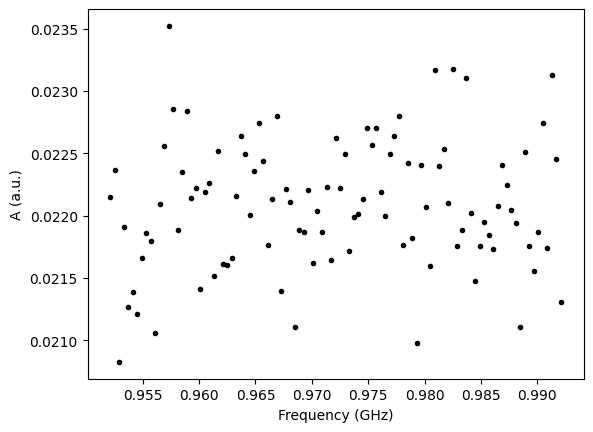

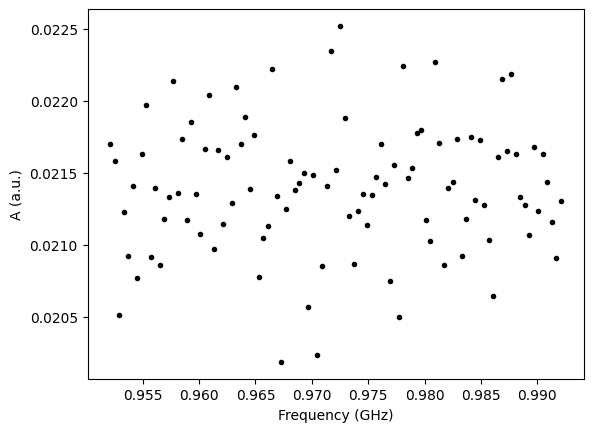

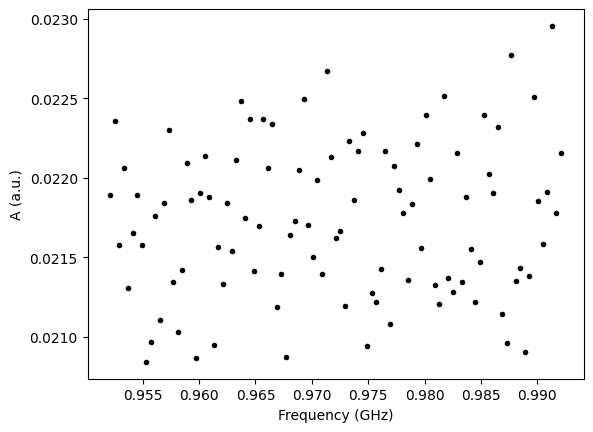

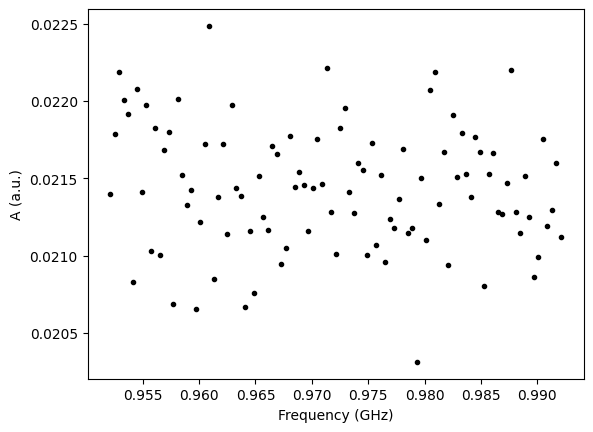

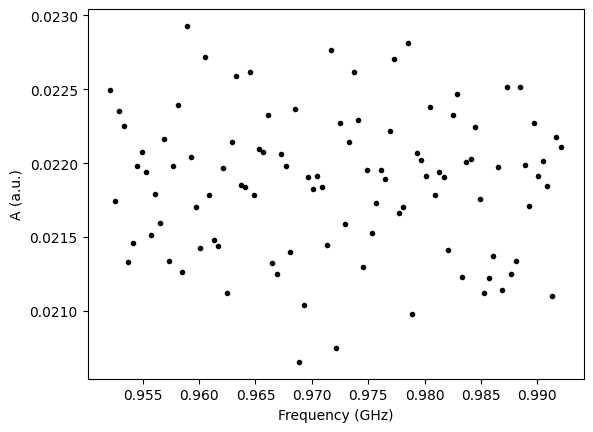

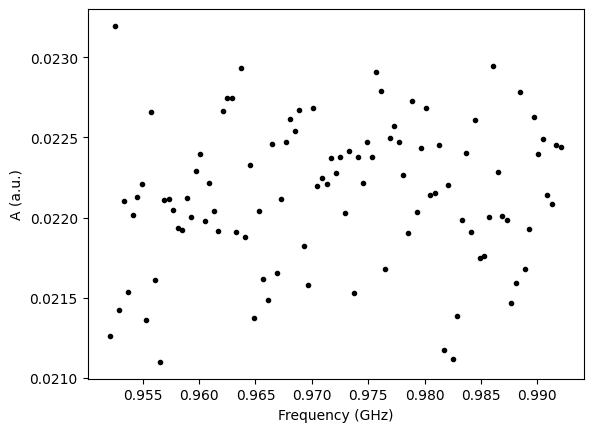

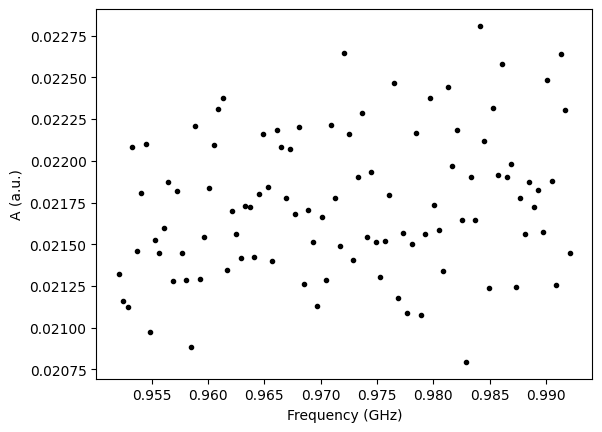

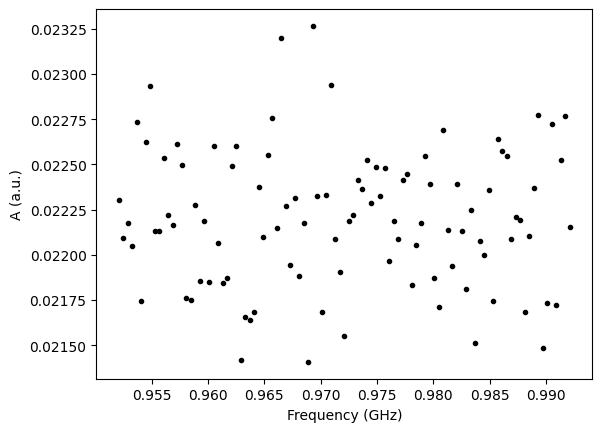

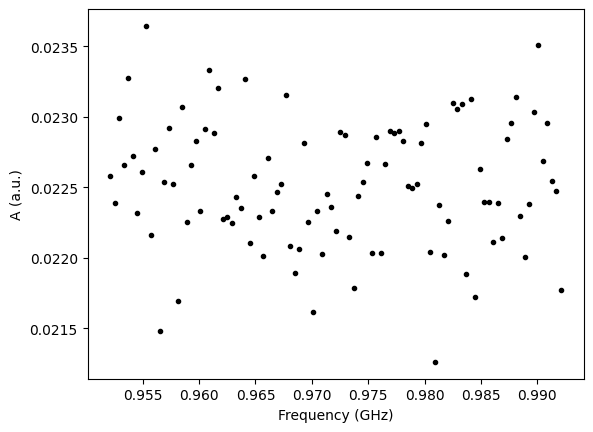

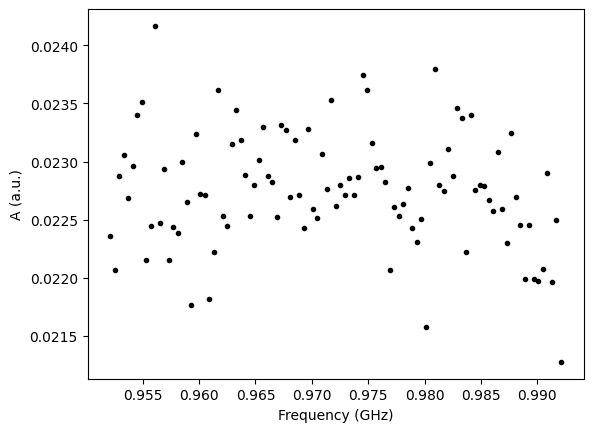

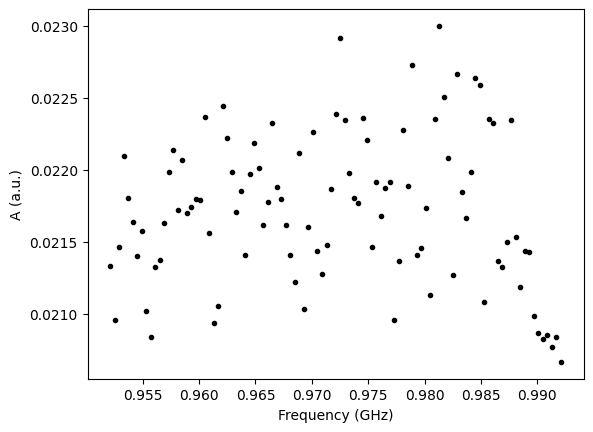

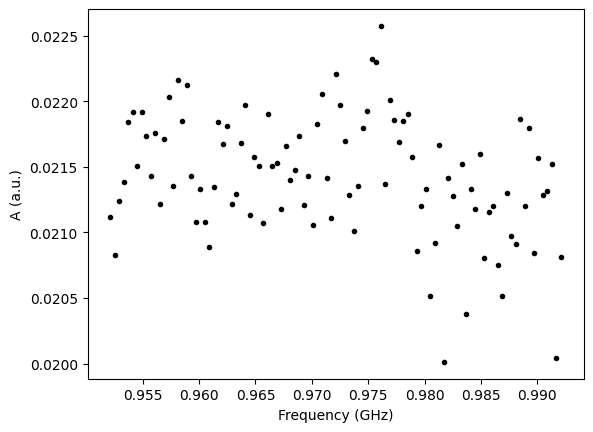

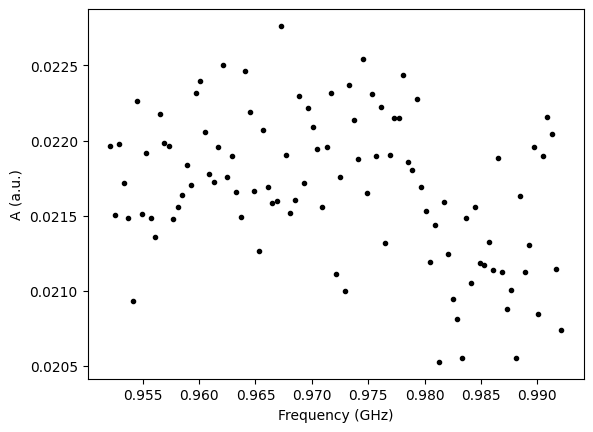

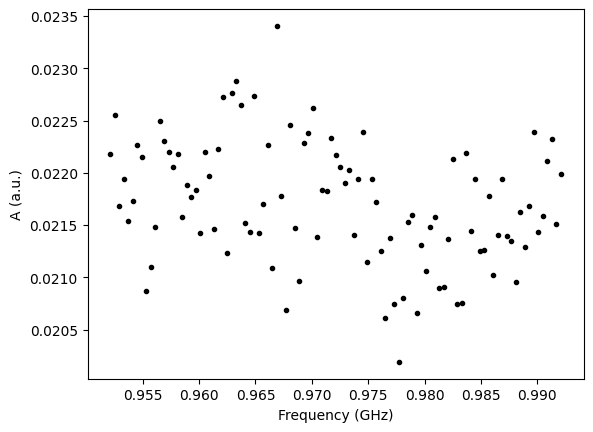

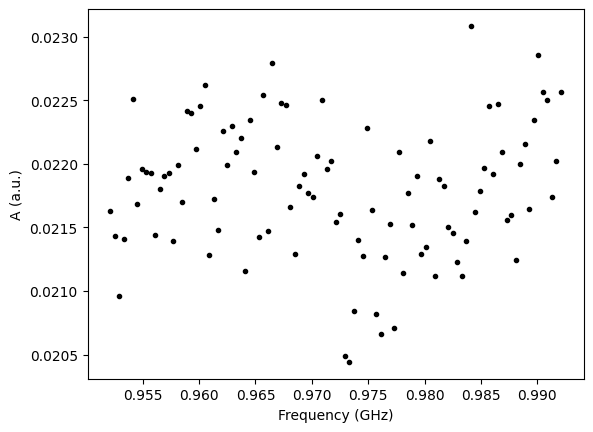

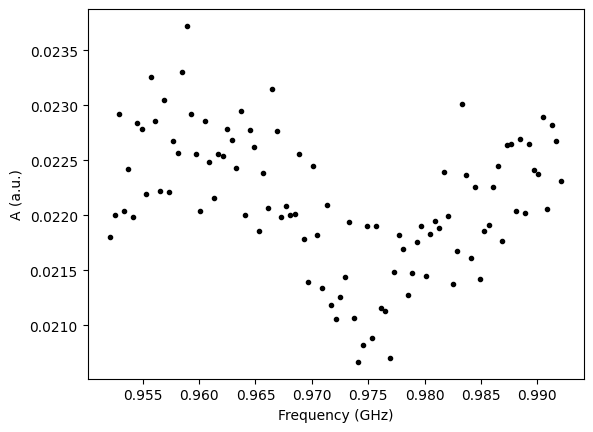

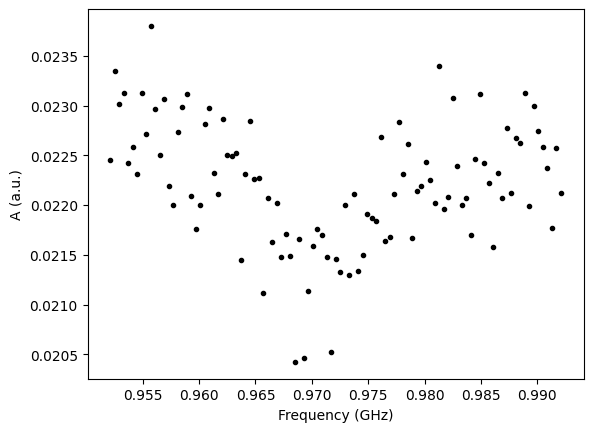

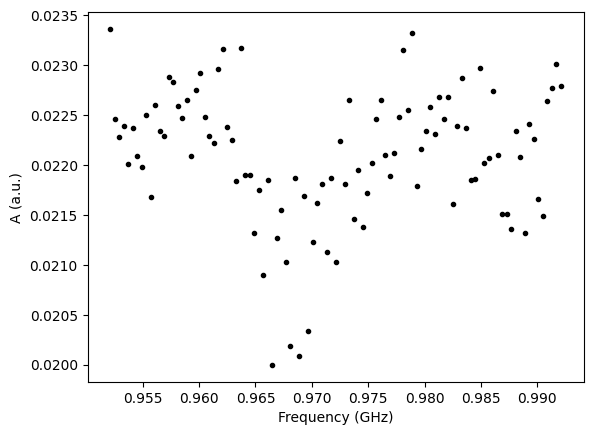

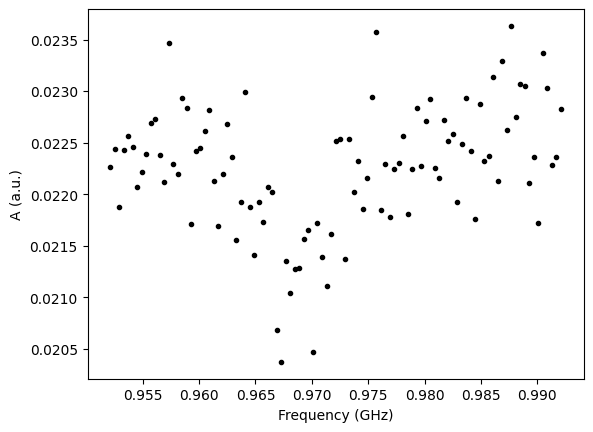

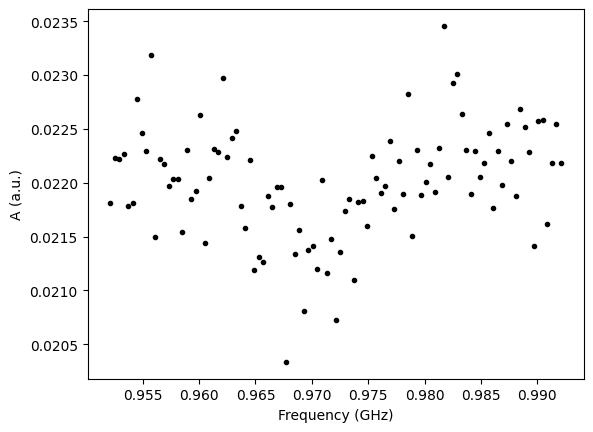

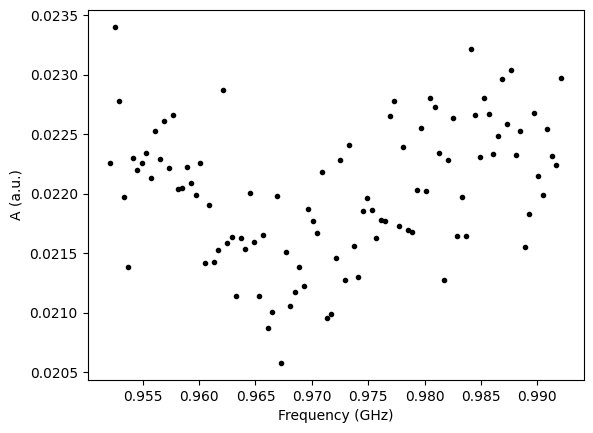

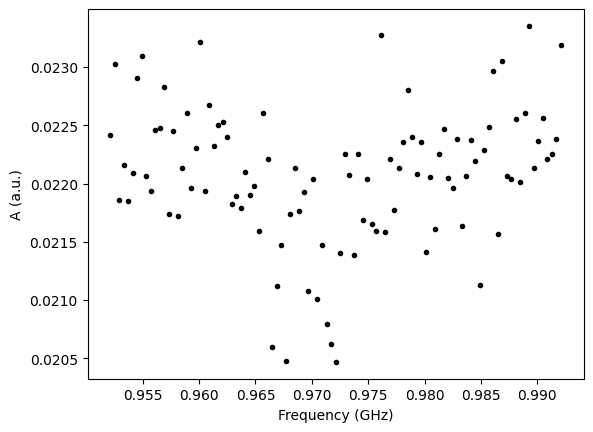

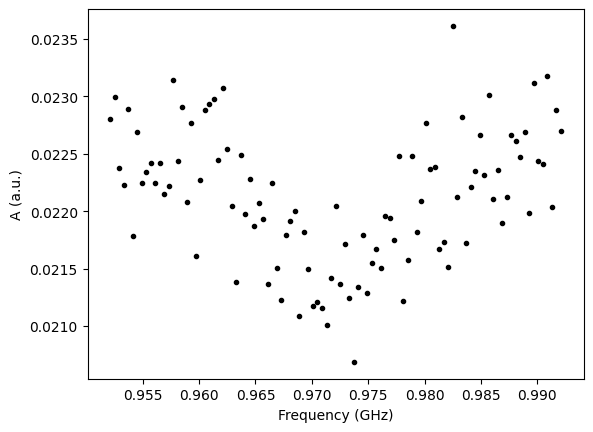

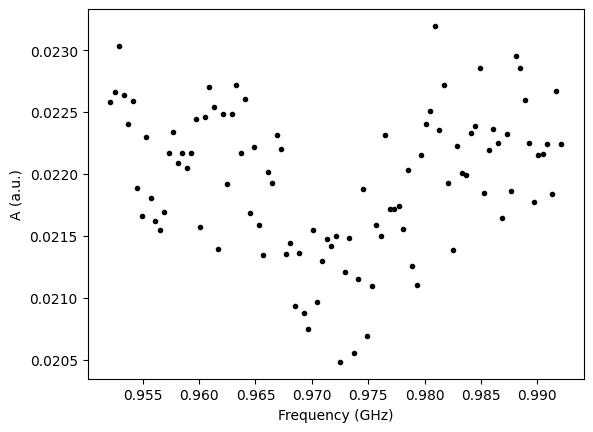

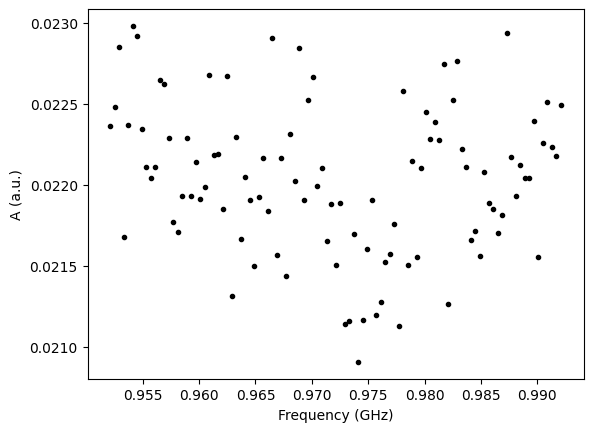

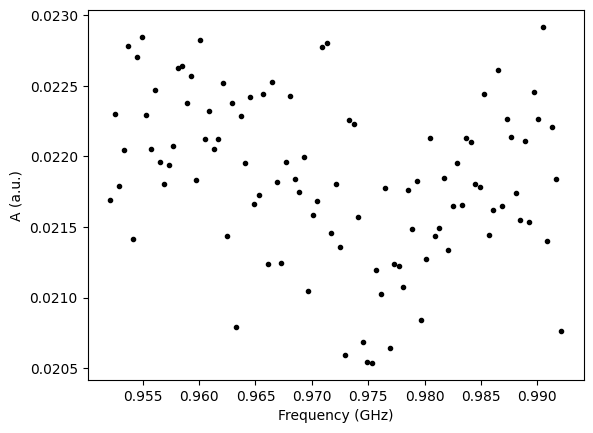

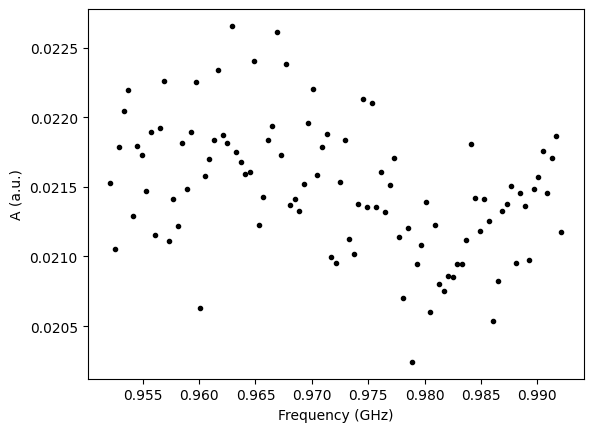

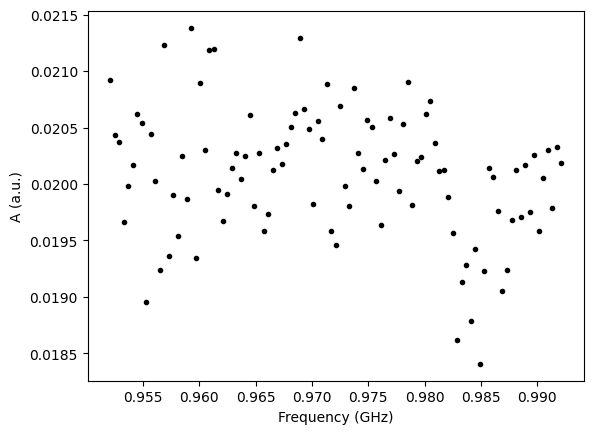

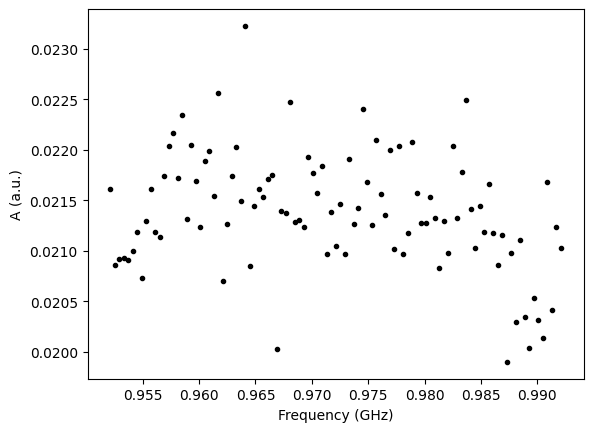

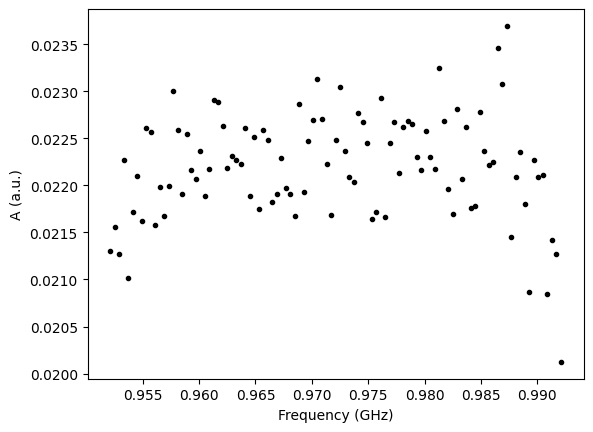

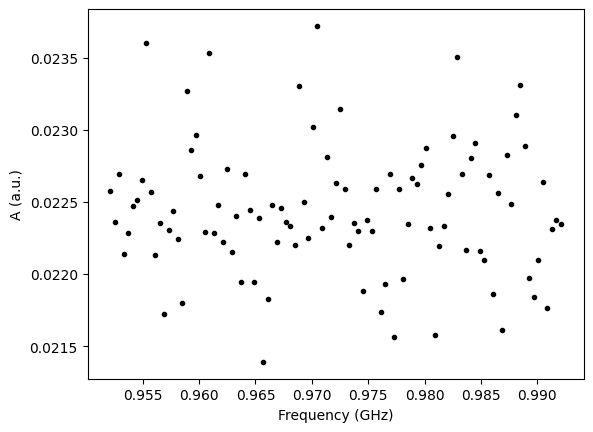

In [1782]:
dc.current_range(10e-3)
start = 8.0e-3
stop = 8.6e-3

current_sweep = np.linspace(start, stop, 31)
dc.output('on')
sweep_qspec_results = []
for current in current_sweep:
    dc.ramp_current(current, 1e-6, 0)
    time.sleep(0.5)
    # run the experiment on qubit 0
    qspec_results = session.run()

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    qspec_res = qspec_results.get_data("qb_spec")
    qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency
    sweep_qspec_results.append(qspec_res)

    # plot measurement data
    fig = plt.figure()
    plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
    plt.ylabel("A (a.u.)")
    plt.xlabel("Frequency (GHz)")

# plt.show()
# dc.ramp_current(5.5e-3,1e-5,0)

Text(0.5, 1.0, 'mag')

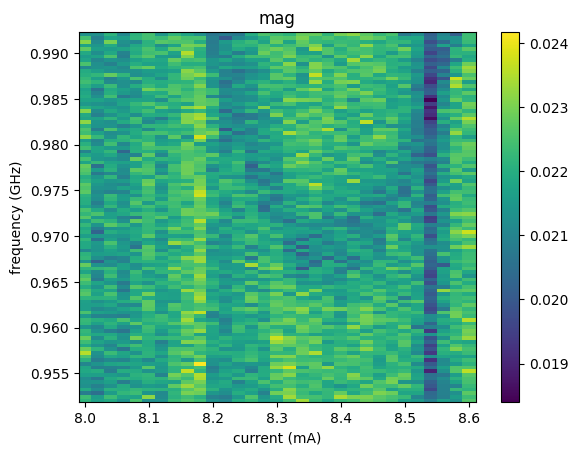

In [1783]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.abs(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(6.2)
# current_sweep[8]*1e3

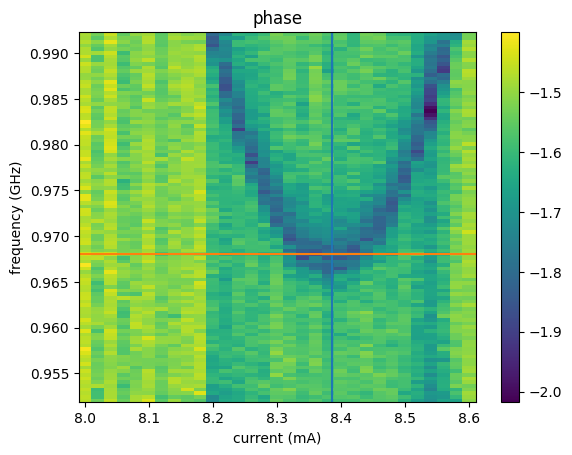

In [1805]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.angle(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
plt.axvline(08.385)
plt.axhline(0.968, color='tab:orange')
# current_sweep[8]*1e3

(0.96, 0.97)

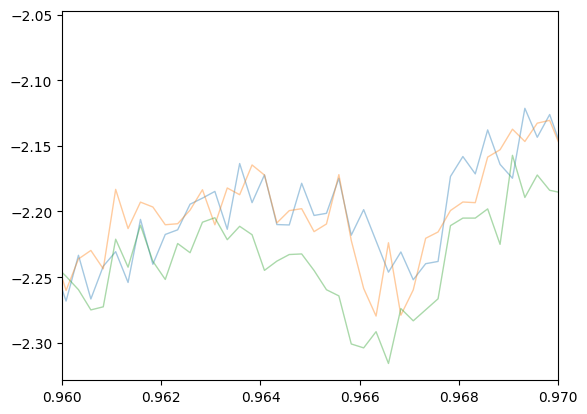

In [1462]:
plt.plot(qspec_freq/1e9, angle_data[:, 11], lw=1, alpha=0.4)
plt.plot(qspec_freq/1e9, angle_data[:, 10], lw=1, alpha=0.4)
plt.plot(qspec_freq/1e9, angle_data[:, 12], lw=1, alpha=0.4)
plt.xlim(0.96, 0.97)

In [1787]:
angle_data = np.angle(sweep_qspec_results).T
angle_data.shape

(101, 31)

In [1788]:
min_arr = np.argmin(angle_data, axis=0)
min_arr.shape

(31,)

In [1789]:
min_freqs = (qspec_freq/1e9)[min_arr]
min_freqs.shape

(31,)

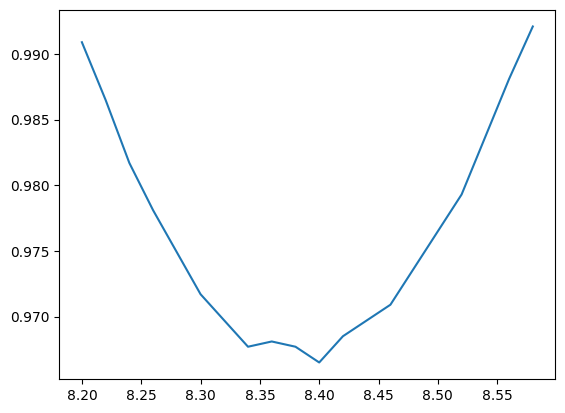

In [1794]:
# plt.plot( current_sweep*1e3, min_arr)
start = 10
stop = -1
plt.plot( (current_sweep*1e3)[start:stop], min_freqs[start:stop])

In [1799]:
min_freqs[start:stop]

array([0.9909, 0.9865, 0.9817, 0.9781, 0.9749, 0.9717, 0.9697, 0.9677,
       0.9681, 0.9677, 0.9665, 0.9685, 0.9697, 0.9709, 0.9737, 0.9765,
       0.9793, 0.9837, 0.9881, 0.9921])

In [1798]:
np.argmin(min_freqs[start:stop])

10

In [1800]:
current_sweep[np.argmin(min_freqs[start:stop])+start]

0.0084

In [1802]:
dc.ramp_current(8.385e-3, 1e-6, 0)

### 3.6 Amplitude Rabi Experiment

Sweep the pulse amplitude of a qubit drive pulse to determine the ideal amplitudes for specific qubit rotation angles

#### 3.6.1 Additional Experimental Parameters

Define the amplitude sweep range and qubit excitation pulse

In [1809]:
measure_q.parameters.resonance_frequency_ge = 0.967e9
# measure_q.parameters.user_defined['pulse_length'] = 50e-9
measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['pulse_length'] = 2000e-9
measure_q.parameters.user_defined['amplitude_pi'] = 0.99
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-25,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15,
│   │   │   'amplitude_pi/2': 0.33
│   │   }
│   )
)

In [1810]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define number of amplitude points, from 0 to 1 in gain
num_amplitudes = 20
amp_min=0.0
amp_max=0.99


#### 3.6.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [1811]:
# function that returns an amplitude Rabi experiment


def amplitude_rabi(drive_pulse, readout_pulse, amplitude_sweep, relax_time = 1e-6):
    exp_rabi = Experiment(
        uid="Amplitude Rabi",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        # inner loop - real time sweep of Rabi ampitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
            # play qubit excitation pulse - pulse amplitude is swept
            with exp_rabi.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_rabi.play(
                    signal="drive", pulse=drive_pulse, amplitude=amplitude_sweep, marker = {"marker1": {"enable": True}}
                )
            # readout pulse and data acquisition
            with exp_rabi.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_rabi.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rabi.acquire(
                    signal="acquire",
                    handle="amp_rabi",
                    kernel=readout_pulse,
                )
            with exp_rabi.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rabi.reserve(signal="measure")
    return exp_rabi

#### 3.6.3 Set Experiment Parameters and Compile

In [1812]:
def create_rabi_amp_sweep(qubit, amp_num, amp_min=0.1, amp_max=0.22, uid="rabi_amp"):
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

In [1813]:
# set signal map for qubit - no experimental calibration necessary, calibration taken from DeviceSetup, i.e. baseline
device_setup.set_calibration(
    measure_q.calibration()
)

drive_pulse = create_rabi_drive_pulse(measure_q)

exp_rabi = amplitude_rabi(
    drive_pulse, readout_pulse, create_rabi_amp_sweep(qubit=measure_q, amp_num=num_amplitudes, amp_min=amp_min, amp_max=amp_max), relax_time = measure_q.parameters.user_defined['reset_length']
)

exp_rabi.set_signal_map(signal_map_default(measure_q))

# compile the experiment on the open instrument session
compiled_rabi = session.compile(exp_rabi)

[2024.07.30 15:08:56.507] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:08:56.512] INFO    Schedule completed. [0.002 s]
[2024.07.30 15:08:56.533] INFO    Code generation completed for all AWGs. [0.020 s]
[2024.07.30 15:08:56.535] INFO    Completed compilation step 1 of 1. [0.025 s]
[2024.07.30 15:08:56.539] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:08:56.540] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 15:08:56.541] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:08:56.543] INFO      device_shfqc        0         11            0           1      8000  
[2024.07.30 15:08:56.544] INFO      device_shfqc_sg     0         71           20           2     16000  
[2024.07.30 15:08:56.545] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:08:56.546] INFO      TOTAL                         82 

#### 3.6.4 Show Pulse Sheet

In [1814]:
show_pulse_sheet("Pulse_Sheets/Amplitude_Rabi", compiled_rabi)

[2024.07.30 15:08:56.556] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 15:08:56.558] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:08:56.566] INFO    Schedule completed. [0.005 s]
[2024.07.30 15:08:56.587] INFO    Code generation completed for all AWGs. [0.019 s]
[2024.07.30 15:08:56.588] INFO    Completed compilation step 1 of 1. [0.027 s]
[2024.07.30 15:08:56.590] INFO    Finished LabOne Q Compiler run.
[2024.07.30 15:08:56.604] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-30-15-08-56.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Amplitude_Rabi_2024-07-30-15-08-56.html

#### 3.6.5 Plot Simulated Outputs

In [1815]:
# Simulate experiment
# plot_simulation(compiled_rabi, 0e-6, 30e-6)

#### 3.6.6 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [1816]:
# run the compiled experiemnt
rabi_results = session.run(compiled_rabi)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/rabi_results_{timestamp}.json")
print(f"File saved as Results_Needed/rabi_results_{timestamp}.json")

[2024.07.30 15:08:56.649] INFO    Configuring the device setup
[2024.07.30 15:08:56.763] INFO    The device setup is configured
[2024.07.30 15:08:57.810] INFO    Starting near-time execution...
[2024.07.30 15:08:58.292] INFO    Estimated RT execution time: 17.04 s.
[2024.07.30 15:09:15.560] INFO    Finished near-time execution.
File saved as Results_Needed/rabi_results_20240730T150915.json


In [1817]:
# get measurement data returned by the instruments
rabi_res = rabi_results.get_data("amp_rabi")

# define amplitude axis from qubit parameters
rabi_amp = rabi_results.get_axis("amp_rabi")[0]

if emulate:
    # create some dummy data if running in emulation mode
    rabi_res = oscillatory(rabi_amp, 10, 0, 1, 1.2) + 0.2 * np.random.rand(
        len(rabi_amp)
    )

Fitted parameters: [ 5.21089129e+00  3.30038534e+00 -4.70766613e-03 -4.40920883e-03]


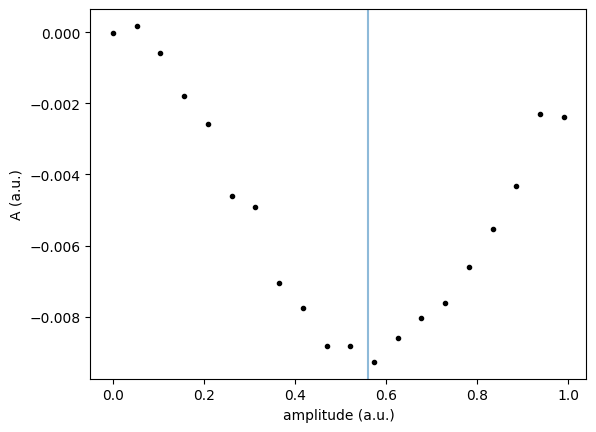

In [1821]:
# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, rabi_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
popt, pcov = oscillatory.fit(rabi_amp, rabi_res, 10, 0, 1, 1.2, plot=False)
print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
# plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
# plt.axvline(0.22)
pi_amp = (np.pi-(np.pi-popt[1]))/(popt[0])
plt.axvline(0.56, alpha=0.5)
# plt.axvline(0.33, alpha=0.5)
# pi_amp = 0.95

In [1822]:
# rabi_amplitude = pi_amp
measure_q.parameters.user_defined['amplitude_pi'] = 0.56
# measure_q.parameters.user_defined['amplitude_pi/2'] = 0.33

# T1

#### 3.7.1 Experiment Parameters

In [1823]:
# measure_q.parameters.user_defined['amplitude_pi'] = 0.95
# measure_q.parameters.user_defined['pulse_length'] = 20e-6
# measure_q.parameters.drive_range = 10

In [1824]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-25,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.56,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15,
│   │   │   'amplitude_pi/2': 0.33
│   │   }
│   )
)

In [1825]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define delay sweep
n_steps = 20
start_delay = 0e-6
stop_delay = 200e-6


#### 3.7.2 Experiment Definition

In [1826]:
# function that returns a T1 experiment


def T1(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_T1 = Experiment(
        uid="T1 Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define T1 experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_T1.acquire_loop_rt(
        uid="T1_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
        
        # inner loop - real time sweep of T1 time delays
        with exp_T1.sweep(
            uid="T1_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - delay is swept
            with exp_T1.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_T1.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_T1.delay(signal="drive", time=time_sweep)
            # readout pulse and data acquisition
            with exp_T1.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_T1.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_T1.acquire(
                    signal="acquire",
                    handle="T1",
                    kernel=readout_pulse,
                )
            with exp_T1.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_T1.reserve(signal="measure")
    return exp_T1

#### 3.7.3 Create Experiment and Signal Map

In [1827]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_T1_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

T1_exp = T1(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

T1_exp.set_signal_map(signal_map_default(measure_q))

compiled_T1 = session.compile(T1_exp)

[2024.07.30 15:10:12.944] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:10:12.949] INFO    Schedule completed. [0.002 s]
[2024.07.30 15:10:12.971] INFO    Code generation completed for all AWGs. [0.021 s]
[2024.07.30 15:10:12.972] INFO    Completed compilation step 1 of 1. [0.026 s]
[2024.07.30 15:10:12.976] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:10:12.977] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 15:10:12.978] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:10:12.979] INFO      device_shfqc        0        112            0           1      8000  
[2024.07.30 15:10:12.981] INFO      device_shfqc_sg     0        148           16          16    128480  
[2024.07.30 15:10:12.982] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:10:12.983] INFO      TOTAL                        260 

#### 3.7.4 Show Pulse Sheet

In [1828]:
show_pulse_sheet("Pulse_Sheets/T1", compiled_T1)

[2024.07.30 15:10:12.992] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 15:10:12.995] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:10:13.002] INFO    Schedule completed. [0.006 s]
[2024.07.30 15:10:13.023] INFO    Code generation completed for all AWGs. [0.020 s]
[2024.07.30 15:10:13.025] INFO    Completed compilation step 1 of 1. [0.028 s]
[2024.07.30 15:10:13.026] INFO    Finished LabOne Q Compiler run.
[2024.07.30 15:10:13.041] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-07-30-15-10-12.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\T1_2024-07-30-15-10-12.html

#### 3.7.5 Plot Simulated Outputs

In [1829]:
# plot_simulation(compiled_T1, 100e-6, 150e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [1830]:
# run the compiled experiemnt
T1_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/T1_results_{timestamp}.json")
print(f"File saved as Results_Needed/T1_results_{timestamp}.json")

[2024.07.30 15:10:28.558] INFO    Configuring the device setup
[2024.07.30 15:10:28.668] INFO    The device setup is configured
[2024.07.30 15:10:29.606] INFO    Starting near-time execution...
[2024.07.30 15:10:30.174] INFO    Estimated RT execution time: 33.42 s.
[2024.07.30 15:11:03.837] INFO    Finished near-time execution.
File saved as Results_Needed/T1_results_20240730T151104.json


In [1831]:
# get measurement data returned by the instruments
T1_res = T1_results.get_data("T1")

# define time axis from qubit parameters
T1_delay = T1_results.get_axis("T1")[0]

if emulate:
    # create dummy data if running in emulation mode
    T1_res = exponential_decay(
        T1_delay, 2e5, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(T1_delay))

Text(0.5, 0, 'delay (us)')

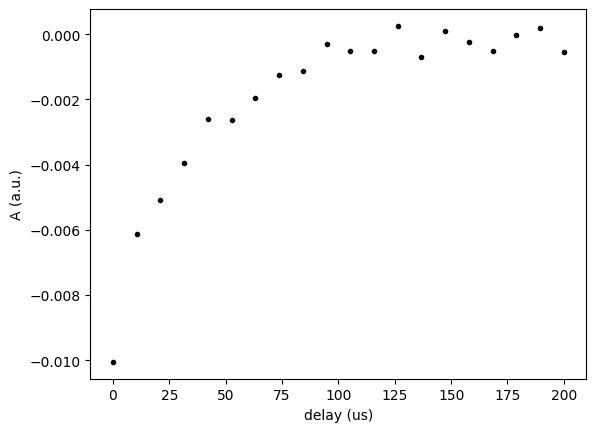

In [1832]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay*1e6, T1_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

Fitted parameters: [ 2.97601160e+04 -1.35771450e-04 -9.39095073e-03]
T1 time 33.60201953463509 us


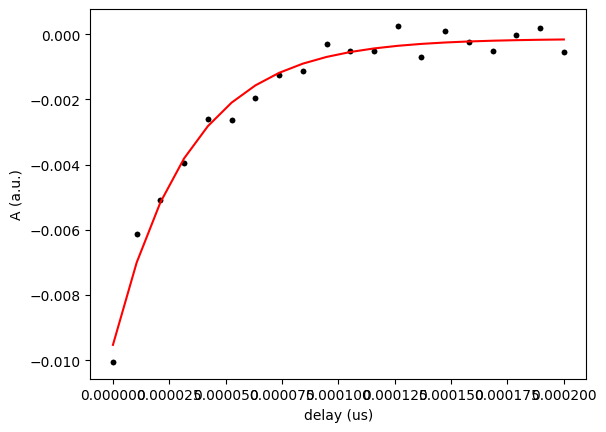

In [1833]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay, T1_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (us)")

# increase number of plot points for smooth plotting of fit results
#delay_plot = np.linspace(T1_delay[0], T1_delay[-1], 5 * len(T1_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = exponential_decay.fit(
   T1_delay,
   T1_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T1 time ' + str(1/popt[0]*1e6) + ' us') 
# plot fit results together with experimental data
#plt.plot(delay_plot, oscillatory_decay(delay_plot, *popt), "-r");

### 3.7 Ramsey Experiment
The Ramsey experiment is different from the experiments above as the length of the drive section changes. Using a right-aligned sweep section and the automatic repetition time makes sure that the experiment is run as efficiently as possible on the Zurich Instruments hardware.

#### 3.7.1 Experiment Parameters

In [1834]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define delay sweep
n_steps = 21
start_delay = 0e-6
stop_delay = 30e-6


#### 3.7.2 Experiment Definition

In [1835]:
# function that returns a Ramsey experiment


def ramsey(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_ramsey = Experiment(
        uid="Ramsey Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey.sweep(
            uid="ramsey_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - pulse delay is swept
            with exp_ramsey.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_ramsey.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_ramsey.delay(signal="drive", time=time_sweep)
                exp_ramsey.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_ramsey.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_ramsey.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_ramsey.acquire(
                    signal="acquire",
                    handle="ramsey",
                    kernel=readout_pulse,
                )
            with exp_ramsey.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_ramsey.reserve(signal="measure")
    return exp_ramsey

In [1836]:
# #measure_q.parameters.user_defined['reset_length'] = 1e-3
# measure_q.parameters.resonance_frequency_ge = measure_q.parameters.resonance_frequency_ge
# print(measure_q)

#### 3.7.3 Create Experiment and Signal Map

In [1837]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_ramsey_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

ramsey_exp = ramsey(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

ramsey_exp.set_signal_map(signal_map_default(measure_q))

compiled_ramsey = session.compile(ramsey_exp)

[2024.07.30 15:11:52.044] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:11:52.050] INFO    Schedule completed. [0.002 s]
[2024.07.30 15:11:52.073] INFO    Code generation completed for all AWGs. [0.022 s]
[2024.07.30 15:11:52.075] INFO    Completed compilation step 1 of 1. [0.028 s]
[2024.07.30 15:11:52.078] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:11:52.080] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 15:11:52.081] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:11:52.082] INFO      device_shfqc        0         89            0           1      8000  
[2024.07.30 15:11:52.083] INFO      device_shfqc_sg     0        115            2           2     16032  
[2024.07.30 15:11:52.084] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:11:52.086] INFO      TOTAL                        204 

#### 3.7.4 Show Pulse Sheet

In [1838]:
show_pulse_sheet("Pulse_Sheets/Ramsey", compiled_ramsey)

[2024.07.30 15:11:52.096] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 15:11:52.098] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:11:52.106] INFO    Schedule completed. [0.006 s]
[2024.07.30 15:11:52.128] INFO    Code generation completed for all AWGs. [0.021 s]
[2024.07.30 15:11:52.130] INFO    Completed compilation step 1 of 1. [0.029 s]
[2024.07.30 15:11:52.131] INFO    Finished LabOne Q Compiler run.
[2024.07.30 15:11:52.145] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Ramsey_2024-07-30-15-11-52.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\Ramsey_2024-07-30-15-11-52.html

#### 3.7.5 Plot Simulated Outputs

In [1839]:
# plot_simulation(compiled_ramsey, 50e-6, 100e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [1840]:
# run the compiled experiemnt
ramsey_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/ramsey_results_{timestamp}_.json")
print(f"File saved as Results/ramsey_results_{timestamp}_.json")

[2024.07.30 15:12:07.264] INFO    Configuring the device setup
[2024.07.30 15:12:07.378] INFO    The device setup is configured
[2024.07.30 15:12:08.337] INFO    Starting near-time execution...
[2024.07.30 15:12:08.888] INFO    Estimated RT execution time: 20.82 s.
[2024.07.30 15:12:29.948] INFO    Finished near-time execution.
File saved as Results/ramsey_results_20240730T151230_.json


In [1841]:
# get measurement data returned by the instruments
ramsey_res = ramsey_results.get_data("ramsey")

# define time axis from qubit parameters
ramsey_delay = ramsey_results.get_axis("ramsey")[0]

if emulate:
    # create dummy data if running in emulation mode
    ramsey_res = oscillatory_decay(
        ramsey_delay, 1e6, 0, 1 / 10e-6, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(ramsey_delay))

Fitted parameters: [ 4.48975440e+05 -5.50027729e+00  5.82476561e+04 -4.40618666e-03
 -4.80168842e-03]


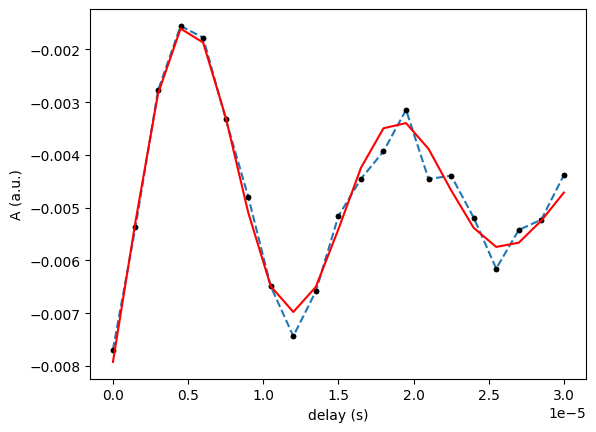

In [1842]:
# plot measurement results
fig = plt.figure()
plt.plot(ramsey_delay, ramsey_res, ".k")
plt.plot(ramsey_delay, ramsey_res, linestyle ='--')

plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(ramsey_delay[0], ramsey_delay[-1], 5 * len(ramsey_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    ramsey_delay,
    ramsey_res,
    1/5e-6,
    0,
    1 / 10e-6,
    0.002,
    0.0008,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

In [1843]:
print(f'T2 Ramsey = {1e6/popt[2]} us')

T2 Ramsey = 17.16807280861634 us


### Ramsey Heralded

In [ ]:
# function that returns a Ramsey experiment


def ramsey_herald(drive_pulse, readout_pulse, time_sweep, num_averages = 8, relax_time = 5e-6):
    exp_ramsey_herald = Experiment(
        uid="Ramsey Experiment_herald",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey_herald.acquire_loop_rt(
        uid="ramsey_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey_herald.sweep(
            uid="ramsey_sweep_herald", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            with exp_ramsey_herald.section(
                uid="readout_section_herald"
            ):
                # play readout pulse on measure line
                exp_ramsey_herald.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_ramsey_herald.acquire(
                    signal="acquire",
                    handle="ramsey_herald",
                    kernel=readout_pulse,
                )
            
            # play qubit excitation pulse - pulse delay is swept
            with exp_ramsey_herald.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT, play_after="readout_section_herald"
            ):
                exp_ramsey_herald.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_ramsey_herald.delay(signal="drive", time=time_sweep)
                exp_ramsey_herald.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_ramsey_herald.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_ramsey_herald.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_ramsey_herald.acquire(
                    signal="acquire",
                    handle="ramsey",
                    kernel=readout_pulse,
                )
            with exp_ramsey_herald.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_ramsey_herald.reserve(signal="measure")
    return exp_ramsey_herald

### 3.9 echo Experiment
Adding a Y180 pulse in middle of Ramsey

In [1844]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

# define delay sweep
n_steps = 21
start_delay = 0e-6
stop_delay = 60e-6


#### 3.9.2 Experiment Definition

In [1845]:
# function that returns an Echo experiment


def echo(x90_pulse, y180_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_echo = Experiment(
        uid="Echo Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Echo experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_echo.acquire_loop_rt(
        uid="echo_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of echo time delays
        with exp_echo.sweep(
            uid="echo_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse
            with exp_echo.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_echo.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
                exp_echo.delay(signal="drive", time=time_sweep/2)
                exp_echo.play(signal="drive", pulse=y180_pulse, phase = 0, marker = {"marker1": {"enable": True}})
                exp_echo.delay(signal="drive", time=time_sweep/2)
                exp_echo.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_echo.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_echo.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_echo.acquire(
                    signal="acquire",
                    handle="echo",
                    kernel=readout_pulse,
                )
            with exp_echo.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_echo.reserve(signal="measure")
    return exp_echo

In [1846]:
# measure_q.parameters.resonance_frequency_ge = 4.5509e9+190e3
# measure_q.parameters.user_defined['reset_length'] = 5e-3
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=967000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=-25,
│   │   readout_range_out=-15,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.56,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.05,
│   │   │   'reset_length': 0.0001,
│   │   │   'readout_range_out': -15,
│   │   │   'readout_range_in': -15,
│   │   │   'amplitude_pi/2': 0.33
│   │   }
│   )
)

#### 3.9.3 Create Experiment and Signal Map

In [1847]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
x90_pulse = create_pi_2_pulse(measure_q)
y180_pulse = create_pi_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

echo_exp = echo(
    x90_pulse=x90_pulse, y180_pulse=y180_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

echo_exp.set_signal_map(signal_map_default(measure_q))

compiled_echo = session.compile(echo_exp)

[2024.07.30 15:13:12.448] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:13:12.455] INFO    Schedule completed. [0.004 s]
[2024.07.30 15:13:12.481] INFO    Code generation completed for all AWGs. [0.025 s]
[2024.07.30 15:13:12.483] INFO    Completed compilation step 1 of 1. [0.032 s]
[2024.07.30 15:13:12.486] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:13:12.487] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 15:13:12.489] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:13:12.490] INFO      device_shfqc        0         90            0           1      8000  
[2024.07.30 15:13:12.491] INFO      device_shfqc_sg     0        159            3           3     24032  
[2024.07.30 15:13:12.493] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 15:13:12.494] INFO      TOTAL                        249 

#### 3.9.4 Show Pulse Sheet

In [1848]:
show_pulse_sheet("Pulse_Sheets/echo", compiled_echo)

[2024.07.30 15:13:12.504] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.07.30 15:13:12.506] INFO    Starting LabOne Q Compiler run...
[2024.07.30 15:13:12.514] INFO    Schedule completed. [0.006 s]
[2024.07.30 15:13:12.572] INFO    Code generation completed for all AWGs. [0.056 s]
[2024.07.30 15:13:12.574] INFO    Completed compilation step 1 of 1. [0.065 s]
[2024.07.30 15:13:12.577] INFO    Finished LabOne Q Compiler run.
[2024.07.30 15:13:12.603] INFO    Writing html file to Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\echo_2024-07-30-15-13-12.html


Z:\projects\2024-fluxonium\measurement\coupler_20240724\LabOneQ\Pulse_Sheets\echo_2024-07-30-15-13-12.html

#### 3.9.5 Plot Simulated Outputs

In [1849]:
# plot_simulation(compiled_echo, 4000e-6, 4050e-6, plot_width=10)

#### 3.9.6 Run, Save, and Plot Results

In [1850]:
# run the compiled experiemnt
echo_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/echo_results_{timestamp}.json")
print(f"File saved as Results/echo_results_{timestamp}.json")

[2024.07.30 15:13:27.591] INFO    Configuring the device setup
[2024.07.30 15:13:27.699] INFO    The device setup is configured
[2024.07.30 15:13:28.786] INFO    Starting near-time execution...
[2024.07.30 15:13:29.308] INFO    Estimated RT execution time: 23.74 s.
[2024.07.30 15:13:53.310] INFO    Finished near-time execution.
File saved as Results/echo_results_20240730T151353.json


In [1851]:
# get measurement data returned by the instruments
echo_res = echo_results.get_data("echo")

# define time axis from qubit parameters
echo_delay = echo_results.get_axis("echo")[0]


Fitted parameters: [ 5.43250430e+04 -4.70847487e-03  4.16884189e-03]
T2e time 18.407716682173852 us


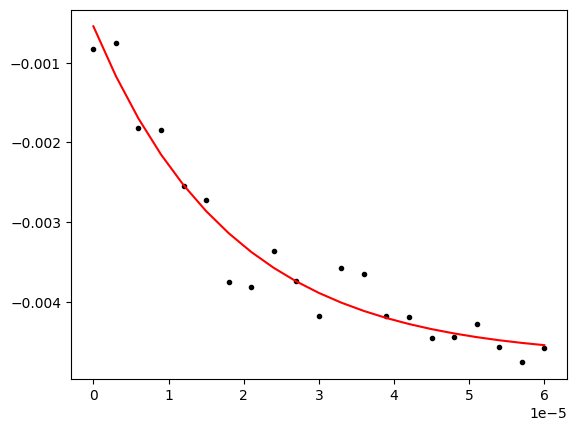

In [1852]:
popt, pcov = exponential_decay.fit(
   echo_delay,
   echo_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 

Fitted parameters: [ 5.43250430e+04 -4.70847487e-03  4.16884189e-03]
T2e time 18.407716682173852 us


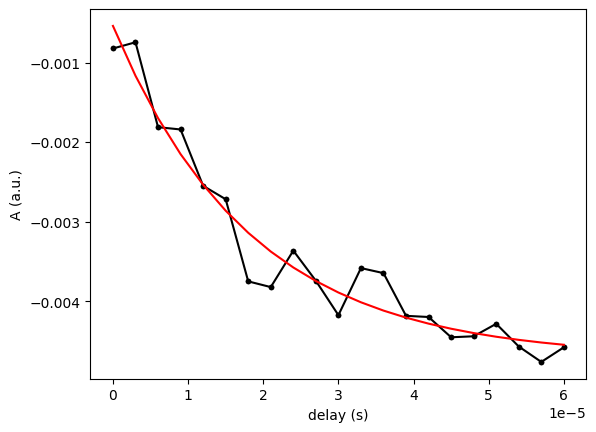

In [1853]:
# plot measurement results (XXX) 5 ms reset
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel(r"delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

popt, pcov = exponential_decay.fit(
   echo_delay,
   echo_res,
   1/3.4e-6,
   -20,
   -20,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T2e time ' + str(1/popt[0]*1e6) + ' us') 